In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Get the current working directory (where the notebook is)
notebook_dir = Path.cwd()

# Move up to the root directory (parent of 'notebooks')
project_root = notebook_dir.parent.parent
# project_root = notebook_dir
os.chdir(project_root)


In [3]:
# from analysis.unsupervised import *
from analysis.supervised import *
from analysis.models import * 

# Load data

In [4]:
import torch
tensors_loaded = torch.load("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl_tensors.pt")
NEED_TO_FLIP = True # cursor told me I didn't have to flip, but if I don't, the probe results suck
if NEED_TO_FLIP:
    activations_start = tensors_loaded['data'].reshape(28, 4198, 3072)
    activations = torch.transpose(activations_start, 0, 1)
    labels_start = tensors_loaded['labels'].reshape(28, 4198)
    labels = torch.transpose(labels_start, 0, 1)
else:
    activations = tensors_loaded['data'].reshape(4198, 28, 3072)
    labels = tensors_loaded['labels'].reshape(4198, 28)

all_rows_internally_same = torch.all(torch.all(labels == labels[:,[0]], dim=1)).item()
assert all_rows_internally_same, "Labels are not internally consistent"
labels = labels[:, 0]

ADD_MEAN_LAYER = True
if ADD_MEAN_LAYER:
    # Calculate mean over layers dimension (dim=1, keepdim=True)
    mean_layer = torch.mean(activations, dim=1, keepdim=True)  

    # Concatenate mean layer to original activations
    activations_with_mean = torch.cat([activations, mean_layer], dim=1)  # New shape: (n_samples, n_layers+1, n_vector_length)
    assert (activations_with_mean[:, 5, :] == activations[:, 5, :]).all()
    activations = activations_with_mean


n_layers = activations.shape[1]
n_samples = activations.shape[0]
n_vector_length = activations.shape[2]
activations.shape, labels.shape

/var/tmp/ipykernel_924014/3014025734.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors_loaded = torch.load("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Inst

(torch.Size([4198, 29, 3072]), torch.Size([4198]))

In [5]:
df = pd.read_csv("datasets/wetransfer_direct/_meta-llamaLlama-3.2-3B-Instruct_prompt_res_activations_3011202404:14:34_rated.pkl_tensors.csv")

In [28]:
def train_test_split_activations(activations, labels):
    assert len(df) == len(activations)
    idx = range(len(df))
    # Randomly shuffle indices
    np.random.seed(42)
    shuffled_idx = np.random.permutation(idx)

    # Split into train/test sets (80/20 split)
    train_idx = shuffled_idx[:int(0.8 * len(idx))]
    test_idx = shuffled_idx[int(0.8 * len(idx)):]

    # Select train/test data using indices
    train_activations = activations[train_idx]
    test_activations = activations[test_idx]
    train_labels = labels[train_idx] 
    test_labels = labels[test_idx]
    return train_activations, train_labels, test_activations, test_labels

train_activations, train_labels, test_activations, test_labels =train_test_split_activations(activations, labels)

def plot_layer_transfer_accuracy_old(test_accuracies_for_plot):

    # Create figure with larger size    
    plt.figure(figsize=(12, 10))

    # Create heatmap
    sns.heatmap(test_accuracies_for_plot, 
                annot=True,  # Show numbers in cells
                fmt='.2f',   # Format numbers to 2 decimal places
                cmap='viridis',  # Color scheme
                xticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on x-axis
                yticklabels=list(range(n_layers-1))+["mean"],  # Layer numbers on y-axis
                cbar_kws={'label': 'Accuracy'})  # Colorbar label

    # Add labels and title
    plt.xlabel('Test Layer')
    plt.ylabel('Train Layer')
    plt.title(f'Cross-Layer Generalization Matrix')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Save the plot if needed
    # save_path = project_root / f"datasets/layer_transfer/cross_layer_generalization.pdf"
    # save_path.parent.mkdir(parents=True, exist_ok=True)
    save_path = "datasets/layer_transfer/cross_layer_generalization.pdf"

    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def plot_layer_transfer_accuracy(test_accuracies_for_plot, specifier = "logistic_regression"):
    # Set style for publication-quality plot
    plt.style.use('seaborn-v0_8-paper')  # Using modern seaborn style for publication-quality plots
    # plt.style.use('seaborn-v0_8-colorblind')
    plt.rcParams.update({
        'axes.spines.top': False,
        'axes.spines.right': False,
        # Remove font family settings since Arial is not available
        'axes.labelpad': 10
    })
    
    # Create figure with publication-friendly size and DPI
    plt.figure(figsize=(10, 8), dpi=300)

    # Create heatmap with refined aesthetics
    heatmap = sns.heatmap(100*test_accuracies_for_plot,
                annot=False,  # Clean look without numbers
                # cmap='viridis',  # Changed to viridis for brighter colors
                xticklabels=[str(i) for i in list(range(n_layers-1))+["mean"]], # Convert to strings
                yticklabels=[str(i) for i in list(range(n_layers-1))+["mean"]], # Convert to strings
                square=True,  # Ensure square cells
                vmin=50,  # Set minimum value to 0.5
                vmax=100,  # Set maximum value to 1.0
                cbar_kws={
                    'label': 'Classification Accuracy',
                    'ticks': [50, 60, 70, 80, 90, 100] #[0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                })

    # Adjust colorbar label size
    heatmap.collections[0].colorbar.ax.set_ylabel('Classification Accuracy (%)', fontsize=16, fontweight='bold')
    heatmap.collections[0].colorbar.ax.tick_params(labelsize=14)

    # Add publication-quality labels
    plt.xlabel('Target Layer', fontsize=16, fontweight='bold')
    plt.ylabel('Source Layer', fontsize=16, fontweight='bold')

    # Refine tick labels
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(rotation=0, fontsize=14)

    # Add subtle grid for better readability
    plt.grid(False)

    # Adjust layout for perfect spacing
    plt.tight_layout()

    # Save in high quality
    save_path = f"datasets/layer_transfer/cross_layer_generalization_{specifier}"
    plt.savefig(f"{save_path}.pdf", bbox_inches='tight', dpi=300, format='pdf')
    plt.savefig(f"{save_path}.png", bbox_inches='tight', dpi=300, format='png')
    
    plt.show()


100%|██████████| 29/29 [00:44<00:00,  1.53s/it]


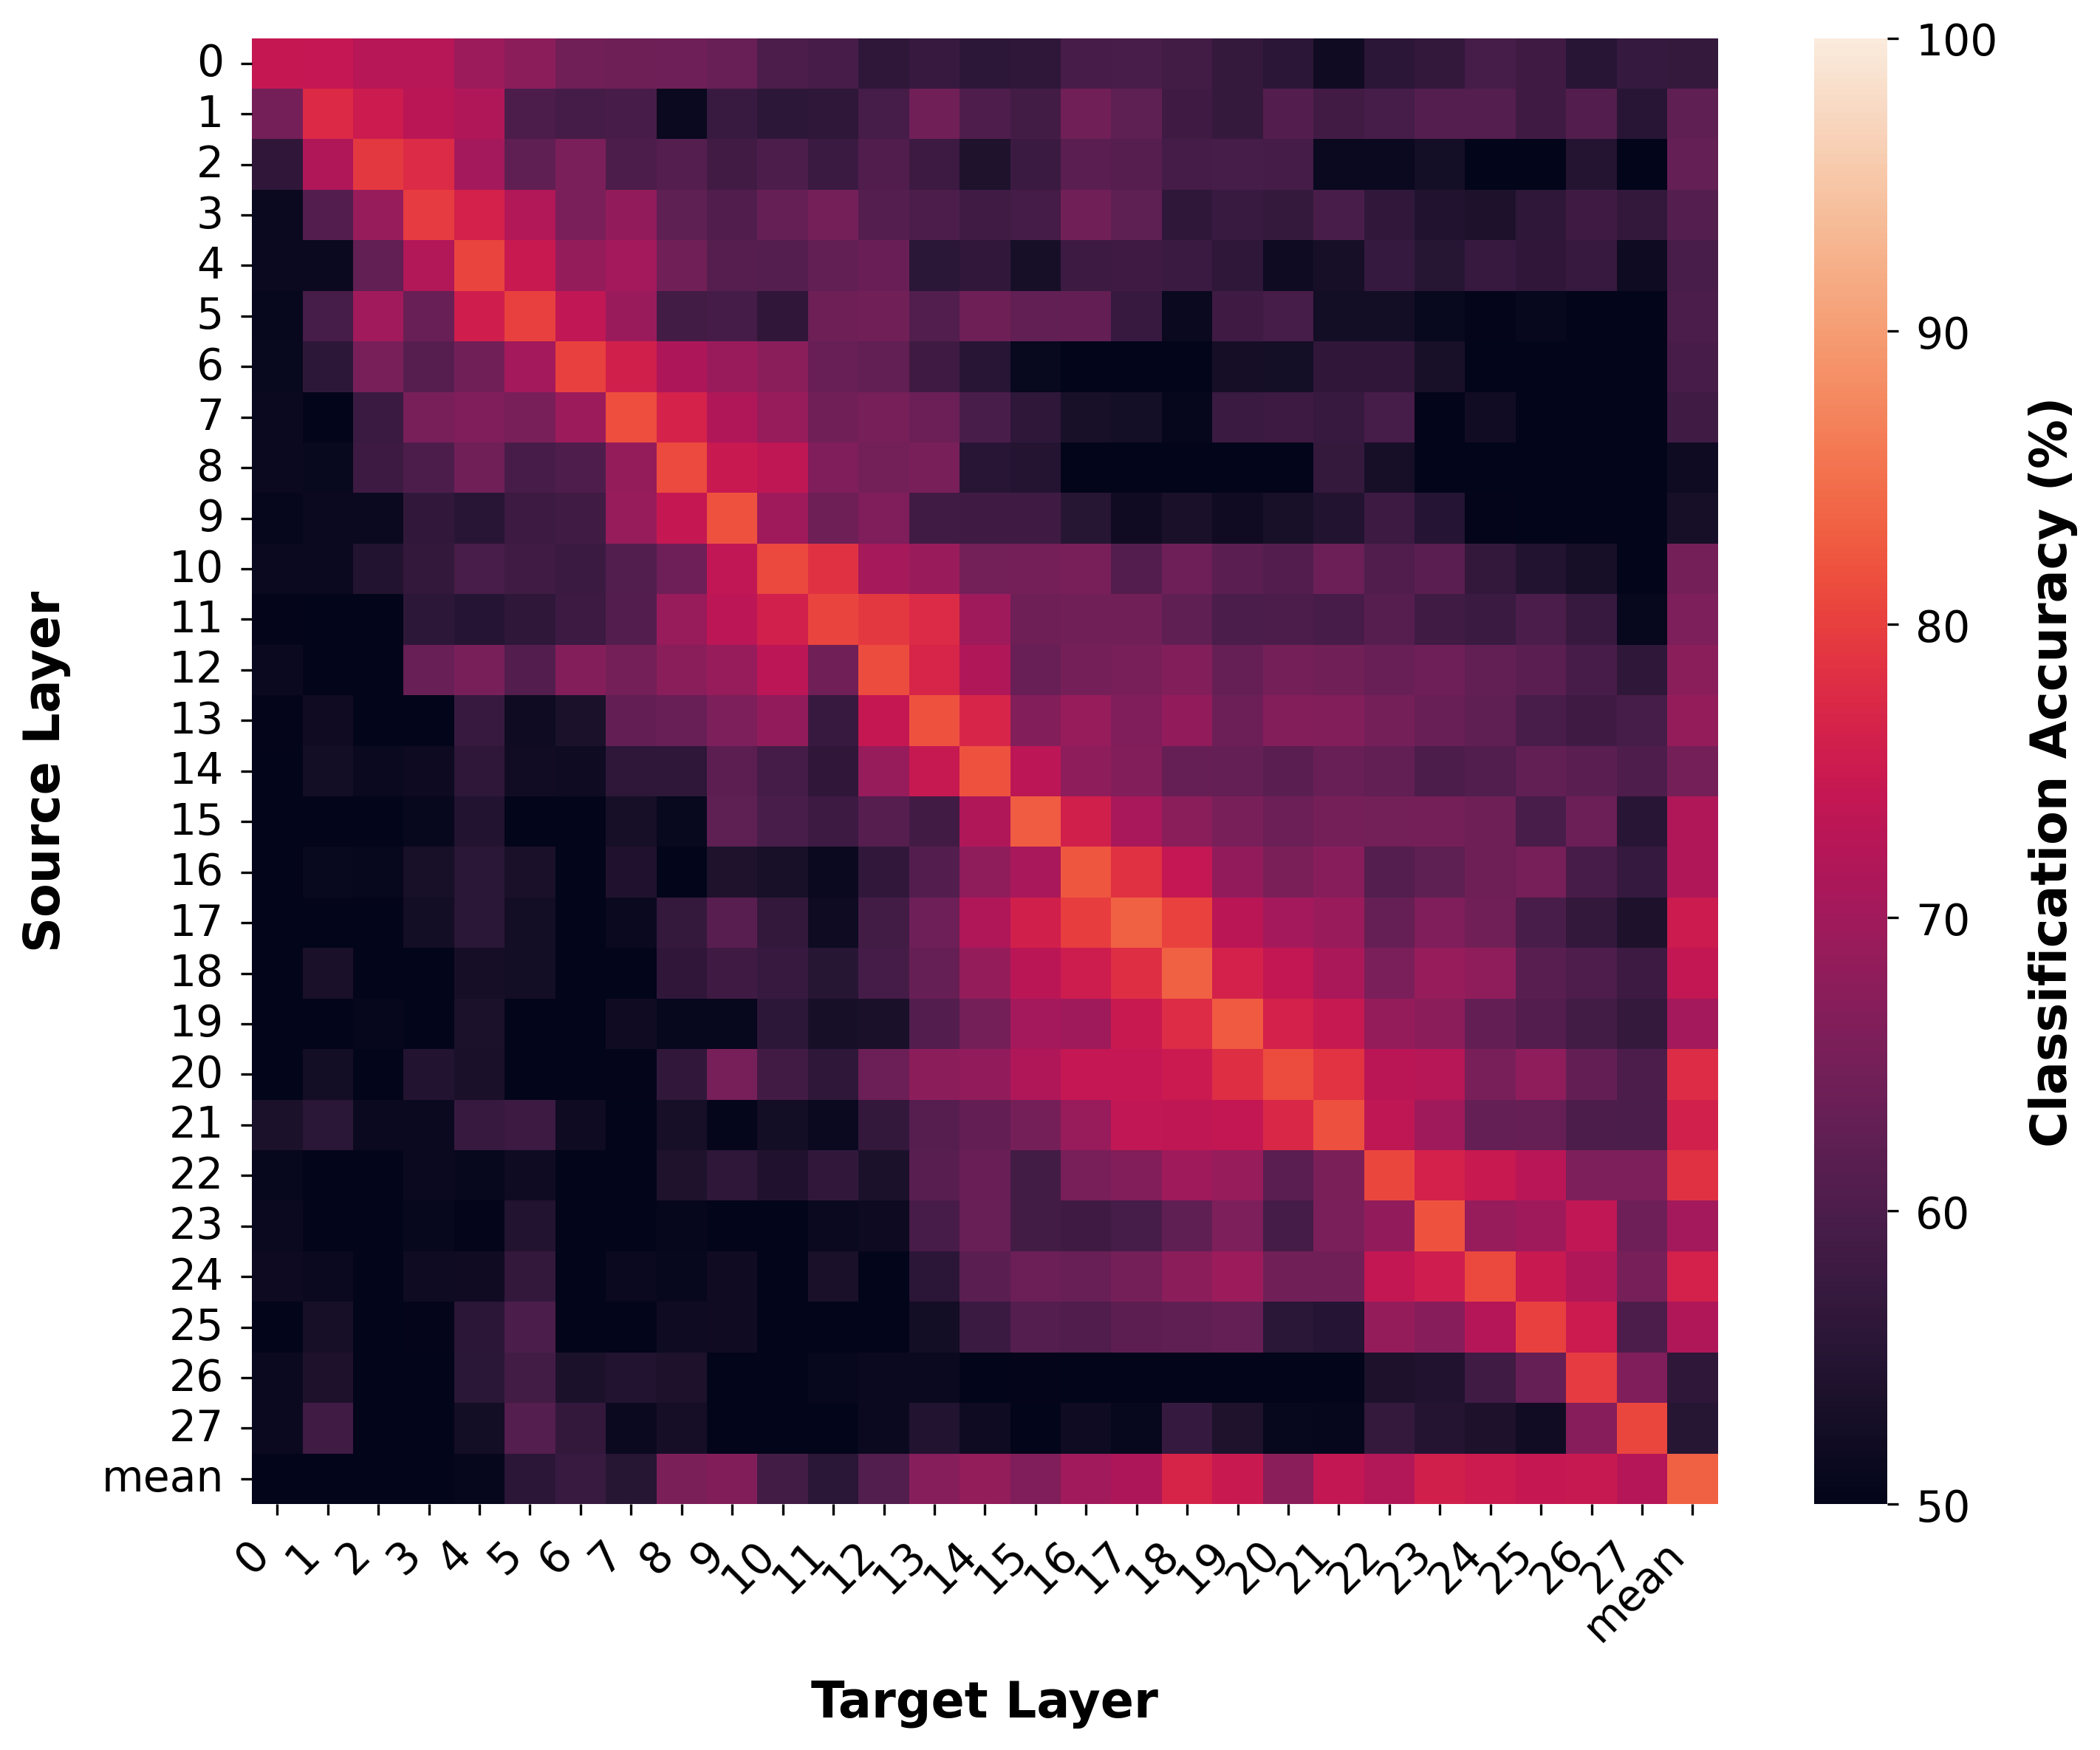

In [31]:
fname_save_template = "datasets/layer_transfer/logistic_regression_layer_accuracies_{save_id}.csv"

for save_id in range(3):  
    test_accuracies = -1*np.ones((n_layers,n_layers))
    train_accuracies = -1*np.ones(n_layers)
    for layer_train in tqdm.tqdm(range(n_layers)):
        log_model = LogisticRegression(solver='lbfgs', max_iter=1000)
        log_model.fit(train_activations[:,layer_train,:], train_labels)
        for layer_test in range(n_layers):
            test_accuracy = log_model.score(test_activations[:,layer_test,:], test_labels)
            test_accuracies[layer_train,layer_test] = test_accuracy
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies, delimiter=",")


l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

plot_layer_transfer_accuracy(test_accuracies_mean, specifier = "logistic_regression")


  0%|          | 0/29 [00:00<?, ?it/s]/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6162
Epoch [20/500], Loss: 0.5885
Epoch [30/500], Loss: 0.5713
Epoch [40/500], Loss: 0.5590
Epoch [50/500], Loss: 0.5496
Epoch [60/500], Loss: 0.5421
Epoch [70/500], Loss: 0.5352
Epoch [80/500], Loss: 0.5293
Epoch [90/500], Loss: 0.5244
Epoch [100/500], Loss: 0.5201
Epoch [110/500], Loss: 0.5164
Epoch [120/500], Loss: 0.5130
Epoch [130/500], Loss: 0.5100
Epoch [140/500], Loss: 0.5073
Epoch [150/500], Loss: 0.5048
Epoch [160/500], Loss: 0.5025
Epoch [170/500], Loss: 0.5004
Epoch [180/500], Loss: 0.4984
Epoch [190/500], Loss: 0.4965
Epoch [200/500], Loss: 0.4947
Epoch [210/500], Loss: 0.4931
Epoch [220/500], Loss: 0.4915
Epoch [230/500], Loss: 0.4900
Epoch [240/500], Loss: 0.4886
Epoch [250/500], Loss: 0.4873
Epoch [260/500], Loss: 0.4860
Epoch [270/500], Loss: 0.4848
Epoch [280/500], Loss: 0.4837
Epoch [290/500], Loss: 0.4826
Epoch [300/500], Loss: 0.4815
Epoch [310/500], Loss: 0.4805
Epoch [320/500], Loss: 0.4795
Epoch [330/500], Loss: 0.4786
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6419
Epoch [20/500], Loss: 0.6072
Epoch [30/500], Loss: 0.5830
Epoch [40/500], Loss: 0.5655
Epoch [50/500], Loss: 0.5520
Epoch [60/500], Loss: 0.5412
Epoch [70/500], Loss: 0.5324
Epoch [80/500], Loss: 0.5251
Epoch [90/500], Loss: 0.5190
Epoch [100/500], Loss: 0.5137
Epoch [110/500], Loss: 0.5092
Epoch [120/500], Loss: 0.5052
Epoch [130/500], Loss: 0.5016
Epoch [140/500], Loss: 0.4983
Epoch [150/500], Loss: 0.4954
Epoch [160/500], Loss: 0.4927
Epoch [170/500], Loss: 0.4903
Epoch [180/500], Loss: 0.4880
Epoch [190/500], Loss: 0.4859
Epoch [200/500], Loss: 0.4839
Epoch [210/500], Loss: 0.4820
Epoch [220/500], Loss: 0.4803
Epoch [230/500], Loss: 0.4787
Epoch [240/500], Loss: 0.4771
Epoch [250/500], Loss: 0.4757
Epoch [260/500], Loss: 0.4743
Epoch [270/500], Loss: 0.4729
Epoch [280/500], Loss: 0.4716
Epoch [290/500], Loss: 0.4704
Epoch [300/500], Loss: 0.4692
Epoch [310/500], Loss: 0.4681
Epoch [320/500], Loss: 0.4669
Epoch [330/500], Loss: 0.4659
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.5964
Epoch [20/500], Loss: 0.5599
Epoch [30/500], Loss: 0.5410
Epoch [40/500], Loss: 0.5281
Epoch [50/500], Loss: 0.5182
Epoch [60/500], Loss: 0.5105
Epoch [70/500], Loss: 0.5042
Epoch [80/500], Loss: 0.4988
Epoch [90/500], Loss: 0.4942
Epoch [100/500], Loss: 0.4900
Epoch [110/500], Loss: 0.4864
Epoch [120/500], Loss: 0.4832
Epoch [130/500], Loss: 0.4802
Epoch [140/500], Loss: 0.4776
Epoch [150/500], Loss: 0.4753
Epoch [160/500], Loss: 0.4731
Epoch [170/500], Loss: 0.4711
Epoch [180/500], Loss: 0.4692
Epoch [190/500], Loss: 0.4675
Epoch [200/500], Loss: 0.4659
Epoch [210/500], Loss: 0.4643
Epoch [220/500], Loss: 0.4628
Epoch [230/500], Loss: 0.4614
Epoch [240/500], Loss: 0.4601
Epoch [250/500], Loss: 0.4588
Epoch [260/500], Loss: 0.4576
Epoch [270/500], Loss: 0.4564
Epoch [280/500], Loss: 0.4552
Epoch [290/500], Loss: 0.4541
Epoch [300/500], Loss: 0.4530
Epoch [310/500], Loss: 0.4519
Epoch [320/500], Loss: 0.4509
Epoch [330/500], Loss: 0.4499
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6659
Epoch [20/500], Loss: 0.6323
Epoch [30/500], Loss: 0.6092
Epoch [40/500], Loss: 0.5893
Epoch [50/500], Loss: 0.5724
Epoch [60/500], Loss: 0.5582
Epoch [70/500], Loss: 0.5463
Epoch [80/500], Loss: 0.5362
Epoch [90/500], Loss: 0.5276
Epoch [100/500], Loss: 0.5202
Epoch [110/500], Loss: 0.5139
Epoch [120/500], Loss: 0.5083
Epoch [130/500], Loss: 0.5035
Epoch [140/500], Loss: 0.4992
Epoch [150/500], Loss: 0.4953
Epoch [160/500], Loss: 0.4918
Epoch [170/500], Loss: 0.4887
Epoch [180/500], Loss: 0.4858
Epoch [190/500], Loss: 0.4832
Epoch [200/500], Loss: 0.4808
Epoch [210/500], Loss: 0.4786
Epoch [220/500], Loss: 0.4766
Epoch [230/500], Loss: 0.4747
Epoch [240/500], Loss: 0.4730
Epoch [250/500], Loss: 0.4714
Epoch [260/500], Loss: 0.4698
Epoch [270/500], Loss: 0.4684
Epoch [280/500], Loss: 0.4670
Epoch [290/500], Loss: 0.4656
Epoch [300/500], Loss: 0.4643
Epoch [310/500], Loss: 0.4630
Epoch [320/500], Loss: 0.4618
Epoch [330/500], Loss: 0.4606
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6471
Epoch [20/500], Loss: 0.6096
Epoch [30/500], Loss: 0.5828
Epoch [40/500], Loss: 0.5616
Epoch [50/500], Loss: 0.5445
Epoch [60/500], Loss: 0.5310
Epoch [70/500], Loss: 0.5200
Epoch [80/500], Loss: 0.5113
Epoch [90/500], Loss: 0.5042
Epoch [100/500], Loss: 0.4984
Epoch [110/500], Loss: 0.4934
Epoch [120/500], Loss: 0.4892
Epoch [130/500], Loss: 0.4853
Epoch [140/500], Loss: 0.4816
Epoch [150/500], Loss: 0.4782
Epoch [160/500], Loss: 0.4749
Epoch [170/500], Loss: 0.4719
Epoch [180/500], Loss: 0.4690
Epoch [190/500], Loss: 0.4664
Epoch [200/500], Loss: 0.4640
Epoch [210/500], Loss: 0.4617
Epoch [220/500], Loss: 0.4595
Epoch [230/500], Loss: 0.4574
Epoch [240/500], Loss: 0.4555
Epoch [250/500], Loss: 0.4536
Epoch [260/500], Loss: 0.4517
Epoch [270/500], Loss: 0.4500
Epoch [280/500], Loss: 0.4483
Epoch [290/500], Loss: 0.4467
Epoch [300/500], Loss: 0.4451
Epoch [310/500], Loss: 0.4436
Epoch [320/500], Loss: 0.4421
Epoch [330/500], Loss: 0.4406
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6095
Epoch [20/500], Loss: 0.5602
Epoch [30/500], Loss: 0.5341
Epoch [40/500], Loss: 0.5185
Epoch [50/500], Loss: 0.5074
Epoch [60/500], Loss: 0.4987
Epoch [70/500], Loss: 0.4915
Epoch [80/500], Loss: 0.4853
Epoch [90/500], Loss: 0.4798
Epoch [100/500], Loss: 0.4747
Epoch [110/500], Loss: 0.4701
Epoch [120/500], Loss: 0.4658
Epoch [130/500], Loss: 0.4617
Epoch [140/500], Loss: 0.4579
Epoch [150/500], Loss: 0.4543
Epoch [160/500], Loss: 0.4510
Epoch [170/500], Loss: 0.4478
Epoch [180/500], Loss: 0.4447
Epoch [190/500], Loss: 0.4418
Epoch [200/500], Loss: 0.4390
Epoch [210/500], Loss: 0.4364
Epoch [220/500], Loss: 0.4339
Epoch [230/500], Loss: 0.4315
Epoch [240/500], Loss: 0.4292
Epoch [250/500], Loss: 0.4270
Epoch [260/500], Loss: 0.4249
Epoch [270/500], Loss: 0.4229
Epoch [280/500], Loss: 0.4210
Epoch [290/500], Loss: 0.4191
Epoch [300/500], Loss: 0.4173
Epoch [310/500], Loss: 0.4155
Epoch [320/500], Loss: 0.4138
Epoch [330/500], Loss: 0.4122
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6352
Epoch [20/500], Loss: 0.5905
Epoch [30/500], Loss: 0.5624
Epoch [40/500], Loss: 0.5412
Epoch [50/500], Loss: 0.5246
Epoch [60/500], Loss: 0.5116
Epoch [70/500], Loss: 0.5010
Epoch [80/500], Loss: 0.4923
Epoch [90/500], Loss: 0.4850
Epoch [100/500], Loss: 0.4788
Epoch [110/500], Loss: 0.4734
Epoch [120/500], Loss: 0.4686
Epoch [130/500], Loss: 0.4642
Epoch [140/500], Loss: 0.4603
Epoch [150/500], Loss: 0.4568
Epoch [160/500], Loss: 0.4534
Epoch [170/500], Loss: 0.4503
Epoch [180/500], Loss: 0.4472
Epoch [190/500], Loss: 0.4443
Epoch [200/500], Loss: 0.4415
Epoch [210/500], Loss: 0.4387
Epoch [220/500], Loss: 0.4361
Epoch [230/500], Loss: 0.4335
Epoch [240/500], Loss: 0.4310
Epoch [250/500], Loss: 0.4286
Epoch [260/500], Loss: 0.4263
Epoch [270/500], Loss: 0.4240
Epoch [280/500], Loss: 0.4218
Epoch [290/500], Loss: 0.4196
Epoch [300/500], Loss: 0.4175
Epoch [310/500], Loss: 0.4154
Epoch [320/500], Loss: 0.4134
Epoch [330/500], Loss: 0.4114
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6194
Epoch [20/500], Loss: 0.5765
Epoch [30/500], Loss: 0.5480
Epoch [40/500], Loss: 0.5277
Epoch [50/500], Loss: 0.5126
Epoch [60/500], Loss: 0.5010
Epoch [70/500], Loss: 0.4918
Epoch [80/500], Loss: 0.4840
Epoch [90/500], Loss: 0.4778
Epoch [100/500], Loss: 0.4727
Epoch [110/500], Loss: 0.4683
Epoch [120/500], Loss: 0.4644
Epoch [130/500], Loss: 0.4609
Epoch [140/500], Loss: 0.4577
Epoch [150/500], Loss: 0.4547
Epoch [160/500], Loss: 0.4519
Epoch [170/500], Loss: 0.4492
Epoch [180/500], Loss: 0.4466
Epoch [190/500], Loss: 0.4442
Epoch [200/500], Loss: 0.4418
Epoch [210/500], Loss: 0.4395
Epoch [220/500], Loss: 0.4373
Epoch [230/500], Loss: 0.4351
Epoch [240/500], Loss: 0.4330
Epoch [250/500], Loss: 0.4308
Epoch [260/500], Loss: 0.4286
Epoch [270/500], Loss: 0.4265
Epoch [280/500], Loss: 0.4244
Epoch [290/500], Loss: 0.4223
Epoch [300/500], Loss: 0.4203
Epoch [310/500], Loss: 0.4184
Epoch [320/500], Loss: 0.4163
Epoch [330/500], Loss: 0.4143
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6060
Epoch [20/500], Loss: 0.5621
Epoch [30/500], Loss: 0.5365
Epoch [40/500], Loss: 0.5195
Epoch [50/500], Loss: 0.5071
Epoch [60/500], Loss: 0.4973
Epoch [70/500], Loss: 0.4893
Epoch [80/500], Loss: 0.4823
Epoch [90/500], Loss: 0.4763
Epoch [100/500], Loss: 0.4710
Epoch [110/500], Loss: 0.4664
Epoch [120/500], Loss: 0.4622
Epoch [130/500], Loss: 0.4582
Epoch [140/500], Loss: 0.4544
Epoch [150/500], Loss: 0.4508
Epoch [160/500], Loss: 0.4472
Epoch [170/500], Loss: 0.4435
Epoch [180/500], Loss: 0.4399
Epoch [190/500], Loss: 0.4365
Epoch [200/500], Loss: 0.4333
Epoch [210/500], Loss: 0.4304
Epoch [220/500], Loss: 0.4275
Epoch [230/500], Loss: 0.4248
Epoch [240/500], Loss: 0.4221
Epoch [250/500], Loss: 0.4196
Epoch [260/500], Loss: 0.4172
Epoch [270/500], Loss: 0.4148
Epoch [280/500], Loss: 0.4126
Epoch [290/500], Loss: 0.4104
Epoch [300/500], Loss: 0.4083
Epoch [310/500], Loss: 0.4063
Epoch [320/500], Loss: 0.4043
Epoch [330/500], Loss: 0.4024
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6180
Epoch [20/500], Loss: 0.5798
Epoch [30/500], Loss: 0.5544
Epoch [40/500], Loss: 0.5361
Epoch [50/500], Loss: 0.5223
Epoch [60/500], Loss: 0.5116
Epoch [70/500], Loss: 0.5031
Epoch [80/500], Loss: 0.4962
Epoch [90/500], Loss: 0.4904
Epoch [100/500], Loss: 0.4856
Epoch [110/500], Loss: 0.4813
Epoch [120/500], Loss: 0.4774
Epoch [130/500], Loss: 0.4739
Epoch [140/500], Loss: 0.4706
Epoch [150/500], Loss: 0.4676
Epoch [160/500], Loss: 0.4648
Epoch [170/500], Loss: 0.4621
Epoch [180/500], Loss: 0.4595
Epoch [190/500], Loss: 0.4571
Epoch [200/500], Loss: 0.4547
Epoch [210/500], Loss: 0.4525
Epoch [220/500], Loss: 0.4503
Epoch [230/500], Loss: 0.4482
Epoch [240/500], Loss: 0.4462
Epoch [250/500], Loss: 0.4442
Epoch [260/500], Loss: 0.4423
Epoch [270/500], Loss: 0.4405
Epoch [280/500], Loss: 0.4386
Epoch [290/500], Loss: 0.4368
Epoch [300/500], Loss: 0.4350
Epoch [310/500], Loss: 0.4332
Epoch [320/500], Loss: 0.4315
Epoch [330/500], Loss: 0.4297
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6474
Epoch [20/500], Loss: 0.6169
Epoch [30/500], Loss: 0.5991
Epoch [40/500], Loss: 0.5854
Epoch [50/500], Loss: 0.5730
Epoch [60/500], Loss: 0.5609
Epoch [70/500], Loss: 0.5490
Epoch [80/500], Loss: 0.5372
Epoch [90/500], Loss: 0.5259
Epoch [100/500], Loss: 0.5156
Epoch [110/500], Loss: 0.5064
Epoch [120/500], Loss: 0.4985
Epoch [130/500], Loss: 0.4918
Epoch [140/500], Loss: 0.4861
Epoch [150/500], Loss: 0.4813
Epoch [160/500], Loss: 0.4773
Epoch [170/500], Loss: 0.4737
Epoch [180/500], Loss: 0.4706
Epoch [190/500], Loss: 0.4677
Epoch [200/500], Loss: 0.4651
Epoch [210/500], Loss: 0.4627
Epoch [220/500], Loss: 0.4605
Epoch [230/500], Loss: 0.4584
Epoch [240/500], Loss: 0.4564
Epoch [250/500], Loss: 0.4544
Epoch [260/500], Loss: 0.4526
Epoch [270/500], Loss: 0.4507
Epoch [280/500], Loss: 0.4490
Epoch [290/500], Loss: 0.4472
Epoch [300/500], Loss: 0.4455
Epoch [310/500], Loss: 0.4437
Epoch [320/500], Loss: 0.4420
Epoch [330/500], Loss: 0.4403
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6432
Epoch [20/500], Loss: 0.6069
Epoch [30/500], Loss: 0.5814
Epoch [40/500], Loss: 0.5610
Epoch [50/500], Loss: 0.5439
Epoch [60/500], Loss: 0.5290
Epoch [70/500], Loss: 0.5151
Epoch [80/500], Loss: 0.5023
Epoch [90/500], Loss: 0.4918
Epoch [100/500], Loss: 0.4832
Epoch [110/500], Loss: 0.4761
Epoch [120/500], Loss: 0.4700
Epoch [130/500], Loss: 0.4649
Epoch [140/500], Loss: 0.4604
Epoch [150/500], Loss: 0.4564
Epoch [160/500], Loss: 0.4528
Epoch [170/500], Loss: 0.4496
Epoch [180/500], Loss: 0.4466
Epoch [190/500], Loss: 0.4437
Epoch [200/500], Loss: 0.4411
Epoch [210/500], Loss: 0.4384
Epoch [220/500], Loss: 0.4360
Epoch [230/500], Loss: 0.4336
Epoch [240/500], Loss: 0.4312
Epoch [250/500], Loss: 0.4290
Epoch [260/500], Loss: 0.4268
Epoch [270/500], Loss: 0.4246
Epoch [280/500], Loss: 0.4225
Epoch [290/500], Loss: 0.4204
Epoch [300/500], Loss: 0.4184
Epoch [310/500], Loss: 0.4163
Epoch [320/500], Loss: 0.4144
Epoch [330/500], Loss: 0.4125
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6402
Epoch [20/500], Loss: 0.6003
Epoch [30/500], Loss: 0.5720
Epoch [40/500], Loss: 0.5504
Epoch [50/500], Loss: 0.5330
Epoch [60/500], Loss: 0.5189
Epoch [70/500], Loss: 0.5070
Epoch [80/500], Loss: 0.4969
Epoch [90/500], Loss: 0.4881
Epoch [100/500], Loss: 0.4803
Epoch [110/500], Loss: 0.4732
Epoch [120/500], Loss: 0.4668
Epoch [130/500], Loss: 0.4611
Epoch [140/500], Loss: 0.4561
Epoch [150/500], Loss: 0.4516
Epoch [160/500], Loss: 0.4475
Epoch [170/500], Loss: 0.4439
Epoch [180/500], Loss: 0.4405
Epoch [190/500], Loss: 0.4375
Epoch [200/500], Loss: 0.4347
Epoch [210/500], Loss: 0.4321
Epoch [220/500], Loss: 0.4296
Epoch [230/500], Loss: 0.4273
Epoch [240/500], Loss: 0.4251
Epoch [250/500], Loss: 0.4230
Epoch [260/500], Loss: 0.4209
Epoch [270/500], Loss: 0.4189
Epoch [280/500], Loss: 0.4170
Epoch [290/500], Loss: 0.4151
Epoch [300/500], Loss: 0.4133
Epoch [310/500], Loss: 0.4115
Epoch [320/500], Loss: 0.4097
Epoch [330/500], Loss: 0.4079
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6502
Epoch [20/500], Loss: 0.6171
Epoch [30/500], Loss: 0.5894
Epoch [40/500], Loss: 0.5661
Epoch [50/500], Loss: 0.5469
Epoch [60/500], Loss: 0.5311
Epoch [70/500], Loss: 0.5181
Epoch [80/500], Loss: 0.5074
Epoch [90/500], Loss: 0.4986
Epoch [100/500], Loss: 0.4912
Epoch [110/500], Loss: 0.4847
Epoch [120/500], Loss: 0.4790
Epoch [130/500], Loss: 0.4739
Epoch [140/500], Loss: 0.4691
Epoch [150/500], Loss: 0.4645
Epoch [160/500], Loss: 0.4601
Epoch [170/500], Loss: 0.4559
Epoch [180/500], Loss: 0.4520
Epoch [190/500], Loss: 0.4484
Epoch [200/500], Loss: 0.4450
Epoch [210/500], Loss: 0.4418
Epoch [220/500], Loss: 0.4387
Epoch [230/500], Loss: 0.4358
Epoch [240/500], Loss: 0.4330
Epoch [250/500], Loss: 0.4304
Epoch [260/500], Loss: 0.4279
Epoch [270/500], Loss: 0.4254
Epoch [280/500], Loss: 0.4231
Epoch [290/500], Loss: 0.4208
Epoch [300/500], Loss: 0.4186
Epoch [310/500], Loss: 0.4165
Epoch [320/500], Loss: 0.4144
Epoch [330/500], Loss: 0.4123
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6226
Epoch [20/500], Loss: 0.5867
Epoch [30/500], Loss: 0.5632
Epoch [40/500], Loss: 0.5448
Epoch [50/500], Loss: 0.5289
Epoch [60/500], Loss: 0.5147
Epoch [70/500], Loss: 0.5021
Epoch [80/500], Loss: 0.4909
Epoch [90/500], Loss: 0.4810
Epoch [100/500], Loss: 0.4724
Epoch [110/500], Loss: 0.4650
Epoch [120/500], Loss: 0.4585
Epoch [130/500], Loss: 0.4527
Epoch [140/500], Loss: 0.4476
Epoch [150/500], Loss: 0.4431
Epoch [160/500], Loss: 0.4390
Epoch [170/500], Loss: 0.4354
Epoch [180/500], Loss: 0.4321
Epoch [190/500], Loss: 0.4291
Epoch [200/500], Loss: 0.4263
Epoch [210/500], Loss: 0.4237
Epoch [220/500], Loss: 0.4213
Epoch [230/500], Loss: 0.4190
Epoch [240/500], Loss: 0.4168
Epoch [250/500], Loss: 0.4147
Epoch [260/500], Loss: 0.4127
Epoch [270/500], Loss: 0.4108
Epoch [280/500], Loss: 0.4089
Epoch [290/500], Loss: 0.4071
Epoch [300/500], Loss: 0.4053
Epoch [310/500], Loss: 0.4036
Epoch [320/500], Loss: 0.4020
Epoch [330/500], Loss: 0.4003
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6250
Epoch [20/500], Loss: 0.5808
Epoch [30/500], Loss: 0.5497
Epoch [40/500], Loss: 0.5247
Epoch [50/500], Loss: 0.5048
Epoch [60/500], Loss: 0.4883
Epoch [70/500], Loss: 0.4751
Epoch [80/500], Loss: 0.4650
Epoch [90/500], Loss: 0.4568
Epoch [100/500], Loss: 0.4500
Epoch [110/500], Loss: 0.4441
Epoch [120/500], Loss: 0.4389
Epoch [130/500], Loss: 0.4342
Epoch [140/500], Loss: 0.4300
Epoch [150/500], Loss: 0.4260
Epoch [160/500], Loss: 0.4223
Epoch [170/500], Loss: 0.4189
Epoch [180/500], Loss: 0.4156
Epoch [190/500], Loss: 0.4125
Epoch [200/500], Loss: 0.4096
Epoch [210/500], Loss: 0.4067
Epoch [220/500], Loss: 0.4040
Epoch [230/500], Loss: 0.4015
Epoch [240/500], Loss: 0.3990
Epoch [250/500], Loss: 0.3965
Epoch [260/500], Loss: 0.3942
Epoch [270/500], Loss: 0.3919
Epoch [280/500], Loss: 0.3897
Epoch [290/500], Loss: 0.3875
Epoch [300/500], Loss: 0.3854
Epoch [310/500], Loss: 0.3834
Epoch [320/500], Loss: 0.3814
Epoch [330/500], Loss: 0.3795
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6470
Epoch [20/500], Loss: 0.6064
Epoch [30/500], Loss: 0.5754
Epoch [40/500], Loss: 0.5511
Epoch [50/500], Loss: 0.5319
Epoch [60/500], Loss: 0.5165
Epoch [70/500], Loss: 0.5040
Epoch [80/500], Loss: 0.4939
Epoch [90/500], Loss: 0.4854
Epoch [100/500], Loss: 0.4784
Epoch [110/500], Loss: 0.4723
Epoch [120/500], Loss: 0.4670
Epoch [130/500], Loss: 0.4624
Epoch [140/500], Loss: 0.4582
Epoch [150/500], Loss: 0.4544
Epoch [160/500], Loss: 0.4509
Epoch [170/500], Loss: 0.4476
Epoch [180/500], Loss: 0.4446
Epoch [190/500], Loss: 0.4417
Epoch [200/500], Loss: 0.4390
Epoch [210/500], Loss: 0.4363
Epoch [220/500], Loss: 0.4338
Epoch [230/500], Loss: 0.4313
Epoch [240/500], Loss: 0.4289
Epoch [250/500], Loss: 0.4265
Epoch [260/500], Loss: 0.4242
Epoch [270/500], Loss: 0.4218
Epoch [280/500], Loss: 0.4196
Epoch [290/500], Loss: 0.4173
Epoch [300/500], Loss: 0.4151
Epoch [310/500], Loss: 0.4131
Epoch [320/500], Loss: 0.4110
Epoch [330/500], Loss: 0.4090
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6275
Epoch [20/500], Loss: 0.5790
Epoch [30/500], Loss: 0.5473
Epoch [40/500], Loss: 0.5251
Epoch [50/500], Loss: 0.5086
Epoch [60/500], Loss: 0.4959
Epoch [70/500], Loss: 0.4857
Epoch [80/500], Loss: 0.4773
Epoch [90/500], Loss: 0.4702
Epoch [100/500], Loss: 0.4642
Epoch [110/500], Loss: 0.4589
Epoch [120/500], Loss: 0.4542
Epoch [130/500], Loss: 0.4500
Epoch [140/500], Loss: 0.4462
Epoch [150/500], Loss: 0.4427
Epoch [160/500], Loss: 0.4394
Epoch [170/500], Loss: 0.4364
Epoch [180/500], Loss: 0.4334
Epoch [190/500], Loss: 0.4306
Epoch [200/500], Loss: 0.4279
Epoch [210/500], Loss: 0.4252
Epoch [220/500], Loss: 0.4227
Epoch [230/500], Loss: 0.4202
Epoch [240/500], Loss: 0.4177
Epoch [250/500], Loss: 0.4153
Epoch [260/500], Loss: 0.4129
Epoch [270/500], Loss: 0.4106
Epoch [280/500], Loss: 0.4083
Epoch [290/500], Loss: 0.4060
Epoch [300/500], Loss: 0.4038
Epoch [310/500], Loss: 0.4017
Epoch [320/500], Loss: 0.3996
Epoch [330/500], Loss: 0.3975
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6440
Epoch [20/500], Loss: 0.5990
Epoch [30/500], Loss: 0.5688
Epoch [40/500], Loss: 0.5478
Epoch [50/500], Loss: 0.5322
Epoch [60/500], Loss: 0.5200
Epoch [70/500], Loss: 0.5100
Epoch [80/500], Loss: 0.5016
Epoch [90/500], Loss: 0.4944
Epoch [100/500], Loss: 0.4882
Epoch [110/500], Loss: 0.4827
Epoch [120/500], Loss: 0.4779
Epoch [130/500], Loss: 0.4735
Epoch [140/500], Loss: 0.4695
Epoch [150/500], Loss: 0.4658
Epoch [160/500], Loss: 0.4622
Epoch [170/500], Loss: 0.4588
Epoch [180/500], Loss: 0.4554
Epoch [190/500], Loss: 0.4522
Epoch [200/500], Loss: 0.4492
Epoch [210/500], Loss: 0.4463
Epoch [220/500], Loss: 0.4435
Epoch [230/500], Loss: 0.4409
Epoch [240/500], Loss: 0.4384
Epoch [250/500], Loss: 0.4359
Epoch [260/500], Loss: 0.4335
Epoch [270/500], Loss: 0.4312
Epoch [280/500], Loss: 0.4290
Epoch [290/500], Loss: 0.4268
Epoch [300/500], Loss: 0.4247
Epoch [310/500], Loss: 0.4225
Epoch [320/500], Loss: 0.4204
Epoch [330/500], Loss: 0.4182
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6451
Epoch [20/500], Loss: 0.6100
Epoch [30/500], Loss: 0.5842
Epoch [40/500], Loss: 0.5620
Epoch [50/500], Loss: 0.5434
Epoch [60/500], Loss: 0.5278
Epoch [70/500], Loss: 0.5148
Epoch [80/500], Loss: 0.5038
Epoch [90/500], Loss: 0.4945
Epoch [100/500], Loss: 0.4865
Epoch [110/500], Loss: 0.4795
Epoch [120/500], Loss: 0.4733
Epoch [130/500], Loss: 0.4678
Epoch [140/500], Loss: 0.4627
Epoch [150/500], Loss: 0.4579
Epoch [160/500], Loss: 0.4535
Epoch [170/500], Loss: 0.4494
Epoch [180/500], Loss: 0.4456
Epoch [190/500], Loss: 0.4420
Epoch [200/500], Loss: 0.4386
Epoch [210/500], Loss: 0.4353
Epoch [220/500], Loss: 0.4322
Epoch [230/500], Loss: 0.4293
Epoch [240/500], Loss: 0.4264
Epoch [250/500], Loss: 0.4237
Epoch [260/500], Loss: 0.4211
Epoch [270/500], Loss: 0.4186
Epoch [280/500], Loss: 0.4162
Epoch [290/500], Loss: 0.4138
Epoch [300/500], Loss: 0.4115
Epoch [310/500], Loss: 0.4092
Epoch [320/500], Loss: 0.4071
Epoch [330/500], Loss: 0.4050
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6363
Epoch [20/500], Loss: 0.5975
Epoch [30/500], Loss: 0.5731
Epoch [40/500], Loss: 0.5553
Epoch [50/500], Loss: 0.5413
Epoch [60/500], Loss: 0.5299
Epoch [70/500], Loss: 0.5203
Epoch [80/500], Loss: 0.5120
Epoch [90/500], Loss: 0.5047
Epoch [100/500], Loss: 0.4980
Epoch [110/500], Loss: 0.4919
Epoch [120/500], Loss: 0.4863
Epoch [130/500], Loss: 0.4811
Epoch [140/500], Loss: 0.4762
Epoch [150/500], Loss: 0.4716
Epoch [160/500], Loss: 0.4672
Epoch [170/500], Loss: 0.4629
Epoch [180/500], Loss: 0.4588
Epoch [190/500], Loss: 0.4549
Epoch [200/500], Loss: 0.4512
Epoch [210/500], Loss: 0.4477
Epoch [220/500], Loss: 0.4443
Epoch [230/500], Loss: 0.4410
Epoch [240/500], Loss: 0.4379
Epoch [250/500], Loss: 0.4348
Epoch [260/500], Loss: 0.4319
Epoch [270/500], Loss: 0.4290
Epoch [280/500], Loss: 0.4262
Epoch [290/500], Loss: 0.4235
Epoch [300/500], Loss: 0.4209
Epoch [310/500], Loss: 0.4183
Epoch [320/500], Loss: 0.4159
Epoch [330/500], Loss: 0.4135
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6443
Epoch [20/500], Loss: 0.6045
Epoch [30/500], Loss: 0.5744
Epoch [40/500], Loss: 0.5501
Epoch [50/500], Loss: 0.5303
Epoch [60/500], Loss: 0.5136
Epoch [70/500], Loss: 0.5002
Epoch [80/500], Loss: 0.4894
Epoch [90/500], Loss: 0.4804
Epoch [100/500], Loss: 0.4729
Epoch [110/500], Loss: 0.4663
Epoch [120/500], Loss: 0.4605
Epoch [130/500], Loss: 0.4553
Epoch [140/500], Loss: 0.4506
Epoch [150/500], Loss: 0.4463
Epoch [160/500], Loss: 0.4423
Epoch [170/500], Loss: 0.4385
Epoch [180/500], Loss: 0.4349
Epoch [190/500], Loss: 0.4314
Epoch [200/500], Loss: 0.4281
Epoch [210/500], Loss: 0.4248
Epoch [220/500], Loss: 0.4218
Epoch [230/500], Loss: 0.4188
Epoch [240/500], Loss: 0.4159
Epoch [250/500], Loss: 0.4130
Epoch [260/500], Loss: 0.4102
Epoch [270/500], Loss: 0.4074
Epoch [280/500], Loss: 0.4047
Epoch [290/500], Loss: 0.4021
Epoch [300/500], Loss: 0.3995
Epoch [310/500], Loss: 0.3970
Epoch [320/500], Loss: 0.3945
Epoch [330/500], Loss: 0.3922
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6687
Epoch [20/500], Loss: 0.6386
Epoch [30/500], Loss: 0.6148
Epoch [40/500], Loss: 0.5940
Epoch [50/500], Loss: 0.5755
Epoch [60/500], Loss: 0.5592
Epoch [70/500], Loss: 0.5449
Epoch [80/500], Loss: 0.5324
Epoch [90/500], Loss: 0.5214
Epoch [100/500], Loss: 0.5117
Epoch [110/500], Loss: 0.5030
Epoch [120/500], Loss: 0.4951
Epoch [130/500], Loss: 0.4880
Epoch [140/500], Loss: 0.4815
Epoch [150/500], Loss: 0.4757
Epoch [160/500], Loss: 0.4704
Epoch [170/500], Loss: 0.4654
Epoch [180/500], Loss: 0.4609
Epoch [190/500], Loss: 0.4566
Epoch [200/500], Loss: 0.4525
Epoch [210/500], Loss: 0.4486
Epoch [220/500], Loss: 0.4450
Epoch [230/500], Loss: 0.4415
Epoch [240/500], Loss: 0.4381
Epoch [250/500], Loss: 0.4349
Epoch [260/500], Loss: 0.4319
Epoch [270/500], Loss: 0.4289
Epoch [280/500], Loss: 0.4259
Epoch [290/500], Loss: 0.4231
Epoch [300/500], Loss: 0.4204
Epoch [310/500], Loss: 0.4177
Epoch [320/500], Loss: 0.4151
Epoch [330/500], Loss: 0.4125
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6428
Epoch [20/500], Loss: 0.6035
Epoch [30/500], Loss: 0.5745
Epoch [40/500], Loss: 0.5517
Epoch [50/500], Loss: 0.5331
Epoch [60/500], Loss: 0.5176
Epoch [70/500], Loss: 0.5046
Epoch [80/500], Loss: 0.4936
Epoch [90/500], Loss: 0.4841
Epoch [100/500], Loss: 0.4759
Epoch [110/500], Loss: 0.4685
Epoch [120/500], Loss: 0.4619
Epoch [130/500], Loss: 0.4560
Epoch [140/500], Loss: 0.4505
Epoch [150/500], Loss: 0.4455
Epoch [160/500], Loss: 0.4408
Epoch [170/500], Loss: 0.4365
Epoch [180/500], Loss: 0.4324
Epoch [190/500], Loss: 0.4285
Epoch [200/500], Loss: 0.4247
Epoch [210/500], Loss: 0.4211
Epoch [220/500], Loss: 0.4175
Epoch [230/500], Loss: 0.4140
Epoch [240/500], Loss: 0.4106
Epoch [250/500], Loss: 0.4073
Epoch [260/500], Loss: 0.4042
Epoch [270/500], Loss: 0.4012
Epoch [280/500], Loss: 0.3983
Epoch [290/500], Loss: 0.3955
Epoch [300/500], Loss: 0.3928
Epoch [310/500], Loss: 0.3902
Epoch [320/500], Loss: 0.3877
Epoch [330/500], Loss: 0.3853
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6024
Epoch [20/500], Loss: 0.5511
Epoch [30/500], Loss: 0.5200
Epoch [40/500], Loss: 0.4982
Epoch [50/500], Loss: 0.4814
Epoch [60/500], Loss: 0.4681
Epoch [70/500], Loss: 0.4571
Epoch [80/500], Loss: 0.4479
Epoch [90/500], Loss: 0.4399
Epoch [100/500], Loss: 0.4330
Epoch [110/500], Loss: 0.4267
Epoch [120/500], Loss: 0.4210
Epoch [130/500], Loss: 0.4157
Epoch [140/500], Loss: 0.4108
Epoch [150/500], Loss: 0.4062
Epoch [160/500], Loss: 0.4020
Epoch [170/500], Loss: 0.3980
Epoch [180/500], Loss: 0.3942
Epoch [190/500], Loss: 0.3907
Epoch [200/500], Loss: 0.3873
Epoch [210/500], Loss: 0.3840
Epoch [220/500], Loss: 0.3809
Epoch [230/500], Loss: 0.3780
Epoch [240/500], Loss: 0.3751
Epoch [250/500], Loss: 0.3723
Epoch [260/500], Loss: 0.3696
Epoch [270/500], Loss: 0.3670
Epoch [280/500], Loss: 0.3645
Epoch [290/500], Loss: 0.3621
Epoch [300/500], Loss: 0.3597
Epoch [310/500], Loss: 0.3575
Epoch [320/500], Loss: 0.3552
Epoch [330/500], Loss: 0.3531
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.5795
Epoch [20/500], Loss: 0.5349
Epoch [30/500], Loss: 0.5095
Epoch [40/500], Loss: 0.4924
Epoch [50/500], Loss: 0.4794
Epoch [60/500], Loss: 0.4689
Epoch [70/500], Loss: 0.4602
Epoch [80/500], Loss: 0.4527
Epoch [90/500], Loss: 0.4461
Epoch [100/500], Loss: 0.4402
Epoch [110/500], Loss: 0.4348
Epoch [120/500], Loss: 0.4298
Epoch [130/500], Loss: 0.4251
Epoch [140/500], Loss: 0.4208
Epoch [150/500], Loss: 0.4166
Epoch [160/500], Loss: 0.4126
Epoch [170/500], Loss: 0.4088
Epoch [180/500], Loss: 0.4052
Epoch [190/500], Loss: 0.4018
Epoch [200/500], Loss: 0.3985
Epoch [210/500], Loss: 0.3953
Epoch [220/500], Loss: 0.3922
Epoch [230/500], Loss: 0.3893
Epoch [240/500], Loss: 0.3865
Epoch [250/500], Loss: 0.3838
Epoch [260/500], Loss: 0.3811
Epoch [270/500], Loss: 0.3785
Epoch [280/500], Loss: 0.3760
Epoch [290/500], Loss: 0.3735
Epoch [300/500], Loss: 0.3710
Epoch [310/500], Loss: 0.3688
Epoch [320/500], Loss: 0.3665
Epoch [330/500], Loss: 0.3644
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6054
Epoch [20/500], Loss: 0.5601
Epoch [30/500], Loss: 0.5335
Epoch [40/500], Loss: 0.5151
Epoch [50/500], Loss: 0.5012
Epoch [60/500], Loss: 0.4898
Epoch [70/500], Loss: 0.4798
Epoch [80/500], Loss: 0.4711
Epoch [90/500], Loss: 0.4630
Epoch [100/500], Loss: 0.4553
Epoch [110/500], Loss: 0.4486
Epoch [120/500], Loss: 0.4425
Epoch [130/500], Loss: 0.4370
Epoch [140/500], Loss: 0.4320
Epoch [150/500], Loss: 0.4272
Epoch [160/500], Loss: 0.4227
Epoch [170/500], Loss: 0.4184
Epoch [180/500], Loss: 0.4144
Epoch [190/500], Loss: 0.4105
Epoch [200/500], Loss: 0.4067
Epoch [210/500], Loss: 0.4031
Epoch [220/500], Loss: 0.3996
Epoch [230/500], Loss: 0.3963
Epoch [240/500], Loss: 0.3931
Epoch [250/500], Loss: 0.3900
Epoch [260/500], Loss: 0.3870
Epoch [270/500], Loss: 0.3842
Epoch [280/500], Loss: 0.3814
Epoch [290/500], Loss: 0.3788
Epoch [300/500], Loss: 0.3762
Epoch [310/500], Loss: 0.3737
Epoch [320/500], Loss: 0.3713
Epoch [330/500], Loss: 0.3690
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6411
Epoch [20/500], Loss: 0.5997
Epoch [30/500], Loss: 0.5703
Epoch [40/500], Loss: 0.5478
Epoch [50/500], Loss: 0.5305
Epoch [60/500], Loss: 0.5170
Epoch [70/500], Loss: 0.5064
Epoch [80/500], Loss: 0.4976
Epoch [90/500], Loss: 0.4903
Epoch [100/500], Loss: 0.4840
Epoch [110/500], Loss: 0.4786
Epoch [120/500], Loss: 0.4738
Epoch [130/500], Loss: 0.4695
Epoch [140/500], Loss: 0.4656
Epoch [150/500], Loss: 0.4619
Epoch [160/500], Loss: 0.4584
Epoch [170/500], Loss: 0.4551
Epoch [180/500], Loss: 0.4520
Epoch [190/500], Loss: 0.4491
Epoch [200/500], Loss: 0.4464
Epoch [210/500], Loss: 0.4437
Epoch [220/500], Loss: 0.4412
Epoch [230/500], Loss: 0.4388
Epoch [240/500], Loss: 0.4365
Epoch [250/500], Loss: 0.4343
Epoch [260/500], Loss: 0.4321
Epoch [270/500], Loss: 0.4300
Epoch [280/500], Loss: 0.4279
Epoch [290/500], Loss: 0.4258
Epoch [300/500], Loss: 0.4238
Epoch [310/500], Loss: 0.4218
Epoch [320/500], Loss: 0.4198
Epoch [330/500], Loss: 0.4179
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6055
Epoch [20/500], Loss: 0.5554
Epoch [30/500], Loss: 0.5223
Epoch [40/500], Loss: 0.4978
Epoch [50/500], Loss: 0.4793
Epoch [60/500], Loss: 0.4651
Epoch [70/500], Loss: 0.4539
Epoch [80/500], Loss: 0.4447
Epoch [90/500], Loss: 0.4370
Epoch [100/500], Loss: 0.4304
Epoch [110/500], Loss: 0.4245
Epoch [120/500], Loss: 0.4192
Epoch [130/500], Loss: 0.4145
Epoch [140/500], Loss: 0.4102
Epoch [150/500], Loss: 0.4063
Epoch [160/500], Loss: 0.4026
Epoch [170/500], Loss: 0.3992
Epoch [180/500], Loss: 0.3961
Epoch [190/500], Loss: 0.3930
Epoch [200/500], Loss: 0.3902
Epoch [210/500], Loss: 0.3874
Epoch [220/500], Loss: 0.3848
Epoch [230/500], Loss: 0.3823
Epoch [240/500], Loss: 0.3799
Epoch [250/500], Loss: 0.3776
Epoch [260/500], Loss: 0.3753
Epoch [270/500], Loss: 0.3731
Epoch [280/500], Loss: 0.3710
Epoch [290/500], Loss: 0.3690
Epoch [300/500], Loss: 0.3670
Epoch [310/500], Loss: 0.3650
Epoch [320/500], Loss: 0.3631
Epoch [330/500], Loss: 0.3613
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


  0%|          | 0/29 [00:00<?, ?it/s]/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6202
Epoch [20/500], Loss: 0.5922
Epoch [30/500], Loss: 0.5781
Epoch [40/500], Loss: 0.5678
Epoch [50/500], Loss: 0.5598
Epoch [60/500], Loss: 0.5533
Epoch [70/500], Loss: 0.5478
Epoch [80/500], Loss: 0.5432
Epoch [90/500], Loss: 0.5391
Epoch [100/500], Loss: 0.5354
Epoch [110/500], Loss: 0.5321
Epoch [120/500], Loss: 0.5290
Epoch [130/500], Loss: 0.5262
Epoch [140/500], Loss: 0.5236
Epoch [150/500], Loss: 0.5212
Epoch [160/500], Loss: 0.5189
Epoch [170/500], Loss: 0.5168
Epoch [180/500], Loss: 0.5148
Epoch [190/500], Loss: 0.5129
Epoch [200/500], Loss: 0.5111
Epoch [210/500], Loss: 0.5094
Epoch [220/500], Loss: 0.5078
Epoch [230/500], Loss: 0.5062
Epoch [240/500], Loss: 0.5047
Epoch [250/500], Loss: 0.5032
Epoch [260/500], Loss: 0.5018
Epoch [270/500], Loss: 0.5005
Epoch [280/500], Loss: 0.4992
Epoch [290/500], Loss: 0.4980
Epoch [300/500], Loss: 0.4968
Epoch [310/500], Loss: 0.4957
Epoch [320/500], Loss: 0.4946
Epoch [330/500], Loss: 0.4935
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6234
Epoch [20/500], Loss: 0.5909
Epoch [30/500], Loss: 0.5718
Epoch [40/500], Loss: 0.5584
Epoch [50/500], Loss: 0.5485
Epoch [60/500], Loss: 0.5408
Epoch [70/500], Loss: 0.5344
Epoch [80/500], Loss: 0.5288
Epoch [90/500], Loss: 0.5241
Epoch [100/500], Loss: 0.5199
Epoch [110/500], Loss: 0.5161
Epoch [120/500], Loss: 0.5127
Epoch [130/500], Loss: 0.5096
Epoch [140/500], Loss: 0.5066
Epoch [150/500], Loss: 0.5037
Epoch [160/500], Loss: 0.5010
Epoch [170/500], Loss: 0.4983
Epoch [180/500], Loss: 0.4958
Epoch [190/500], Loss: 0.4934
Epoch [200/500], Loss: 0.4911
Epoch [210/500], Loss: 0.4889
Epoch [220/500], Loss: 0.4867
Epoch [230/500], Loss: 0.4846
Epoch [240/500], Loss: 0.4825
Epoch [250/500], Loss: 0.4805
Epoch [260/500], Loss: 0.4787
Epoch [270/500], Loss: 0.4770
Epoch [280/500], Loss: 0.4753
Epoch [290/500], Loss: 0.4738
Epoch [300/500], Loss: 0.4723
Epoch [310/500], Loss: 0.4709
Epoch [320/500], Loss: 0.4695
Epoch [330/500], Loss: 0.4682
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6202
Epoch [20/500], Loss: 0.5892
Epoch [30/500], Loss: 0.5694
Epoch [40/500], Loss: 0.5553
Epoch [50/500], Loss: 0.5441
Epoch [60/500], Loss: 0.5351
Epoch [70/500], Loss: 0.5275
Epoch [80/500], Loss: 0.5211
Epoch [90/500], Loss: 0.5156
Epoch [100/500], Loss: 0.5109
Epoch [110/500], Loss: 0.5067
Epoch [120/500], Loss: 0.5028
Epoch [130/500], Loss: 0.4991
Epoch [140/500], Loss: 0.4959
Epoch [150/500], Loss: 0.4929
Epoch [160/500], Loss: 0.4902
Epoch [170/500], Loss: 0.4876
Epoch [180/500], Loss: 0.4853
Epoch [190/500], Loss: 0.4832
Epoch [200/500], Loss: 0.4812
Epoch [210/500], Loss: 0.4794
Epoch [220/500], Loss: 0.4776
Epoch [230/500], Loss: 0.4759
Epoch [240/500], Loss: 0.4743
Epoch [250/500], Loss: 0.4728
Epoch [260/500], Loss: 0.4711
Epoch [270/500], Loss: 0.4693
Epoch [280/500], Loss: 0.4675
Epoch [290/500], Loss: 0.4660
Epoch [300/500], Loss: 0.4646
Epoch [310/500], Loss: 0.4633
Epoch [320/500], Loss: 0.4620
Epoch [330/500], Loss: 0.4608
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6178
Epoch [20/500], Loss: 0.5818
Epoch [30/500], Loss: 0.5602
Epoch [40/500], Loss: 0.5447
Epoch [50/500], Loss: 0.5328
Epoch [60/500], Loss: 0.5231
Epoch [70/500], Loss: 0.5150
Epoch [80/500], Loss: 0.5082
Epoch [90/500], Loss: 0.5025
Epoch [100/500], Loss: 0.4976
Epoch [110/500], Loss: 0.4933
Epoch [120/500], Loss: 0.4894
Epoch [130/500], Loss: 0.4859
Epoch [140/500], Loss: 0.4828
Epoch [150/500], Loss: 0.4798
Epoch [160/500], Loss: 0.4771
Epoch [170/500], Loss: 0.4745
Epoch [180/500], Loss: 0.4720
Epoch [190/500], Loss: 0.4697
Epoch [200/500], Loss: 0.4675
Epoch [210/500], Loss: 0.4654
Epoch [220/500], Loss: 0.4634
Epoch [230/500], Loss: 0.4615
Epoch [240/500], Loss: 0.4597
Epoch [250/500], Loss: 0.4579
Epoch [260/500], Loss: 0.4563
Epoch [270/500], Loss: 0.4547
Epoch [280/500], Loss: 0.4531
Epoch [290/500], Loss: 0.4516
Epoch [300/500], Loss: 0.4502
Epoch [310/500], Loss: 0.4488
Epoch [320/500], Loss: 0.4474
Epoch [330/500], Loss: 0.4461
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6131
Epoch [20/500], Loss: 0.5793
Epoch [30/500], Loss: 0.5589
Epoch [40/500], Loss: 0.5432
Epoch [50/500], Loss: 0.5302
Epoch [60/500], Loss: 0.5188
Epoch [70/500], Loss: 0.5086
Epoch [80/500], Loss: 0.4992
Epoch [90/500], Loss: 0.4905
Epoch [100/500], Loss: 0.4826
Epoch [110/500], Loss: 0.4757
Epoch [120/500], Loss: 0.4697
Epoch [130/500], Loss: 0.4644
Epoch [140/500], Loss: 0.4597
Epoch [150/500], Loss: 0.4555
Epoch [160/500], Loss: 0.4518
Epoch [170/500], Loss: 0.4484
Epoch [180/500], Loss: 0.4454
Epoch [190/500], Loss: 0.4426
Epoch [200/500], Loss: 0.4400
Epoch [210/500], Loss: 0.4376
Epoch [220/500], Loss: 0.4353
Epoch [230/500], Loss: 0.4331
Epoch [240/500], Loss: 0.4310
Epoch [250/500], Loss: 0.4290
Epoch [260/500], Loss: 0.4270
Epoch [270/500], Loss: 0.4252
Epoch [280/500], Loss: 0.4234
Epoch [290/500], Loss: 0.4217
Epoch [300/500], Loss: 0.4200
Epoch [310/500], Loss: 0.4183
Epoch [320/500], Loss: 0.4167
Epoch [330/500], Loss: 0.4151
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6239
Epoch [20/500], Loss: 0.5913
Epoch [30/500], Loss: 0.5708
Epoch [40/500], Loss: 0.5556
Epoch [50/500], Loss: 0.5436
Epoch [60/500], Loss: 0.5334
Epoch [70/500], Loss: 0.5244
Epoch [80/500], Loss: 0.5163
Epoch [90/500], Loss: 0.5090
Epoch [100/500], Loss: 0.5024
Epoch [110/500], Loss: 0.4964
Epoch [120/500], Loss: 0.4906
Epoch [130/500], Loss: 0.4851
Epoch [140/500], Loss: 0.4799
Epoch [150/500], Loss: 0.4750
Epoch [160/500], Loss: 0.4703
Epoch [170/500], Loss: 0.4658
Epoch [180/500], Loss: 0.4615
Epoch [190/500], Loss: 0.4575
Epoch [200/500], Loss: 0.4538
Epoch [210/500], Loss: 0.4503
Epoch [220/500], Loss: 0.4470
Epoch [230/500], Loss: 0.4440
Epoch [240/500], Loss: 0.4411
Epoch [250/500], Loss: 0.4383
Epoch [260/500], Loss: 0.4358
Epoch [270/500], Loss: 0.4333
Epoch [280/500], Loss: 0.4310
Epoch [290/500], Loss: 0.4287
Epoch [300/500], Loss: 0.4265
Epoch [310/500], Loss: 0.4244
Epoch [320/500], Loss: 0.4223
Epoch [330/500], Loss: 0.4203
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6591
Epoch [20/500], Loss: 0.6209
Epoch [30/500], Loss: 0.5930
Epoch [40/500], Loss: 0.5719
Epoch [50/500], Loss: 0.5553
Epoch [60/500], Loss: 0.5422
Epoch [70/500], Loss: 0.5318
Epoch [80/500], Loss: 0.5233
Epoch [90/500], Loss: 0.5162
Epoch [100/500], Loss: 0.5102
Epoch [110/500], Loss: 0.5050
Epoch [120/500], Loss: 0.5005
Epoch [130/500], Loss: 0.4965
Epoch [140/500], Loss: 0.4929
Epoch [150/500], Loss: 0.4895
Epoch [160/500], Loss: 0.4863
Epoch [170/500], Loss: 0.4832
Epoch [180/500], Loss: 0.4803
Epoch [190/500], Loss: 0.4774
Epoch [200/500], Loss: 0.4746
Epoch [210/500], Loss: 0.4718
Epoch [220/500], Loss: 0.4690
Epoch [230/500], Loss: 0.4662
Epoch [240/500], Loss: 0.4635
Epoch [250/500], Loss: 0.4607
Epoch [260/500], Loss: 0.4580
Epoch [270/500], Loss: 0.4552
Epoch [280/500], Loss: 0.4525
Epoch [290/500], Loss: 0.4497
Epoch [300/500], Loss: 0.4469
Epoch [310/500], Loss: 0.4442
Epoch [320/500], Loss: 0.4414
Epoch [330/500], Loss: 0.4387
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6421
Epoch [20/500], Loss: 0.5969
Epoch [30/500], Loss: 0.5681
Epoch [40/500], Loss: 0.5475
Epoch [50/500], Loss: 0.5306
Epoch [60/500], Loss: 0.5144
Epoch [70/500], Loss: 0.5011
Epoch [80/500], Loss: 0.4908
Epoch [90/500], Loss: 0.4827
Epoch [100/500], Loss: 0.4759
Epoch [110/500], Loss: 0.4702
Epoch [120/500], Loss: 0.4652
Epoch [130/500], Loss: 0.4609
Epoch [140/500], Loss: 0.4570
Epoch [150/500], Loss: 0.4534
Epoch [160/500], Loss: 0.4501
Epoch [170/500], Loss: 0.4471
Epoch [180/500], Loss: 0.4441
Epoch [190/500], Loss: 0.4414
Epoch [200/500], Loss: 0.4388
Epoch [210/500], Loss: 0.4364
Epoch [220/500], Loss: 0.4340
Epoch [230/500], Loss: 0.4318
Epoch [240/500], Loss: 0.4296
Epoch [250/500], Loss: 0.4275
Epoch [260/500], Loss: 0.4255
Epoch [270/500], Loss: 0.4236
Epoch [280/500], Loss: 0.4217
Epoch [290/500], Loss: 0.4198
Epoch [300/500], Loss: 0.4180
Epoch [310/500], Loss: 0.4163
Epoch [320/500], Loss: 0.4146
Epoch [330/500], Loss: 0.4129
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6372
Epoch [20/500], Loss: 0.5882
Epoch [30/500], Loss: 0.5562
Epoch [40/500], Loss: 0.5342
Epoch [50/500], Loss: 0.5179
Epoch [60/500], Loss: 0.5054
Epoch [70/500], Loss: 0.4954
Epoch [80/500], Loss: 0.4872
Epoch [90/500], Loss: 0.4802
Epoch [100/500], Loss: 0.4741
Epoch [110/500], Loss: 0.4688
Epoch [120/500], Loss: 0.4641
Epoch [130/500], Loss: 0.4600
Epoch [140/500], Loss: 0.4563
Epoch [150/500], Loss: 0.4529
Epoch [160/500], Loss: 0.4498
Epoch [170/500], Loss: 0.4468
Epoch [180/500], Loss: 0.4441
Epoch [190/500], Loss: 0.4416
Epoch [200/500], Loss: 0.4392
Epoch [210/500], Loss: 0.4368
Epoch [220/500], Loss: 0.4346
Epoch [230/500], Loss: 0.4324
Epoch [240/500], Loss: 0.4303
Epoch [250/500], Loss: 0.4283
Epoch [260/500], Loss: 0.4264
Epoch [270/500], Loss: 0.4244
Epoch [280/500], Loss: 0.4226
Epoch [290/500], Loss: 0.4207
Epoch [300/500], Loss: 0.4189
Epoch [310/500], Loss: 0.4171
Epoch [320/500], Loss: 0.4153
Epoch [330/500], Loss: 0.4135
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6376
Epoch [20/500], Loss: 0.5996
Epoch [30/500], Loss: 0.5729
Epoch [40/500], Loss: 0.5529
Epoch [50/500], Loss: 0.5375
Epoch [60/500], Loss: 0.5254
Epoch [70/500], Loss: 0.5158
Epoch [80/500], Loss: 0.5078
Epoch [90/500], Loss: 0.5012
Epoch [100/500], Loss: 0.4954
Epoch [110/500], Loss: 0.4904
Epoch [120/500], Loss: 0.4860
Epoch [130/500], Loss: 0.4818
Epoch [140/500], Loss: 0.4778
Epoch [150/500], Loss: 0.4743
Epoch [160/500], Loss: 0.4711
Epoch [170/500], Loss: 0.4683
Epoch [180/500], Loss: 0.4656
Epoch [190/500], Loss: 0.4630
Epoch [200/500], Loss: 0.4606
Epoch [210/500], Loss: 0.4583
Epoch [220/500], Loss: 0.4561
Epoch [230/500], Loss: 0.4540
Epoch [240/500], Loss: 0.4519
Epoch [250/500], Loss: 0.4499
Epoch [260/500], Loss: 0.4479
Epoch [270/500], Loss: 0.4460
Epoch [280/500], Loss: 0.4441
Epoch [290/500], Loss: 0.4422
Epoch [300/500], Loss: 0.4404
Epoch [310/500], Loss: 0.4385
Epoch [320/500], Loss: 0.4368
Epoch [330/500], Loss: 0.4351
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6502
Epoch [20/500], Loss: 0.6198
Epoch [30/500], Loss: 0.5957
Epoch [40/500], Loss: 0.5752
Epoch [50/500], Loss: 0.5580
Epoch [60/500], Loss: 0.5436
Epoch [70/500], Loss: 0.5316
Epoch [80/500], Loss: 0.5216
Epoch [90/500], Loss: 0.5132
Epoch [100/500], Loss: 0.5060
Epoch [110/500], Loss: 0.4999
Epoch [120/500], Loss: 0.4947
Epoch [130/500], Loss: 0.4901
Epoch [140/500], Loss: 0.4859
Epoch [150/500], Loss: 0.4822
Epoch [160/500], Loss: 0.4789
Epoch [170/500], Loss: 0.4757
Epoch [180/500], Loss: 0.4727
Epoch [190/500], Loss: 0.4699
Epoch [200/500], Loss: 0.4674
Epoch [210/500], Loss: 0.4650
Epoch [220/500], Loss: 0.4629
Epoch [230/500], Loss: 0.4609
Epoch [240/500], Loss: 0.4589
Epoch [250/500], Loss: 0.4571
Epoch [260/500], Loss: 0.4554
Epoch [270/500], Loss: 0.4538
Epoch [280/500], Loss: 0.4522
Epoch [290/500], Loss: 0.4506
Epoch [300/500], Loss: 0.4491
Epoch [310/500], Loss: 0.4476
Epoch [320/500], Loss: 0.4462
Epoch [330/500], Loss: 0.4447
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6254
Epoch [20/500], Loss: 0.5800
Epoch [30/500], Loss: 0.5521
Epoch [40/500], Loss: 0.5331
Epoch [50/500], Loss: 0.5190
Epoch [60/500], Loss: 0.5081
Epoch [70/500], Loss: 0.4992
Epoch [80/500], Loss: 0.4918
Epoch [90/500], Loss: 0.4855
Epoch [100/500], Loss: 0.4798
Epoch [110/500], Loss: 0.4745
Epoch [120/500], Loss: 0.4697
Epoch [130/500], Loss: 0.4654
Epoch [140/500], Loss: 0.4616
Epoch [150/500], Loss: 0.4583
Epoch [160/500], Loss: 0.4552
Epoch [170/500], Loss: 0.4524
Epoch [180/500], Loss: 0.4498
Epoch [190/500], Loss: 0.4474
Epoch [200/500], Loss: 0.4452
Epoch [210/500], Loss: 0.4430
Epoch [220/500], Loss: 0.4409
Epoch [230/500], Loss: 0.4389
Epoch [240/500], Loss: 0.4370
Epoch [250/500], Loss: 0.4351
Epoch [260/500], Loss: 0.4333
Epoch [270/500], Loss: 0.4315
Epoch [280/500], Loss: 0.4298
Epoch [290/500], Loss: 0.4280
Epoch [300/500], Loss: 0.4263
Epoch [310/500], Loss: 0.4247
Epoch [320/500], Loss: 0.4230
Epoch [330/500], Loss: 0.4214
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6274
Epoch [20/500], Loss: 0.5758
Epoch [30/500], Loss: 0.5433
Epoch [40/500], Loss: 0.5199
Epoch [50/500], Loss: 0.5018
Epoch [60/500], Loss: 0.4885
Epoch [70/500], Loss: 0.4784
Epoch [80/500], Loss: 0.4704
Epoch [90/500], Loss: 0.4640
Epoch [100/500], Loss: 0.4586
Epoch [110/500], Loss: 0.4540
Epoch [120/500], Loss: 0.4498
Epoch [130/500], Loss: 0.4461
Epoch [140/500], Loss: 0.4426
Epoch [150/500], Loss: 0.4395
Epoch [160/500], Loss: 0.4366
Epoch [170/500], Loss: 0.4338
Epoch [180/500], Loss: 0.4311
Epoch [190/500], Loss: 0.4285
Epoch [200/500], Loss: 0.4261
Epoch [210/500], Loss: 0.4237
Epoch [220/500], Loss: 0.4213
Epoch [230/500], Loss: 0.4191
Epoch [240/500], Loss: 0.4169
Epoch [250/500], Loss: 0.4147
Epoch [260/500], Loss: 0.4126
Epoch [270/500], Loss: 0.4105
Epoch [280/500], Loss: 0.4085
Epoch [290/500], Loss: 0.4065
Epoch [300/500], Loss: 0.4046
Epoch [310/500], Loss: 0.4027
Epoch [320/500], Loss: 0.4008
Epoch [330/500], Loss: 0.3990
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6482
Epoch [20/500], Loss: 0.6098
Epoch [30/500], Loss: 0.5813
Epoch [40/500], Loss: 0.5592
Epoch [50/500], Loss: 0.5416
Epoch [60/500], Loss: 0.5274
Epoch [70/500], Loss: 0.5159
Epoch [80/500], Loss: 0.5063
Epoch [90/500], Loss: 0.4984
Epoch [100/500], Loss: 0.4917
Epoch [110/500], Loss: 0.4858
Epoch [120/500], Loss: 0.4807
Epoch [130/500], Loss: 0.4761
Epoch [140/500], Loss: 0.4721
Epoch [150/500], Loss: 0.4684
Epoch [160/500], Loss: 0.4651
Epoch [170/500], Loss: 0.4621
Epoch [180/500], Loss: 0.4592
Epoch [190/500], Loss: 0.4566
Epoch [200/500], Loss: 0.4541
Epoch [210/500], Loss: 0.4517
Epoch [220/500], Loss: 0.4495
Epoch [230/500], Loss: 0.4473
Epoch [240/500], Loss: 0.4452
Epoch [250/500], Loss: 0.4431
Epoch [260/500], Loss: 0.4411
Epoch [270/500], Loss: 0.4392
Epoch [280/500], Loss: 0.4372
Epoch [290/500], Loss: 0.4353
Epoch [300/500], Loss: 0.4335
Epoch [310/500], Loss: 0.4317
Epoch [320/500], Loss: 0.4299
Epoch [330/500], Loss: 0.4281
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6595
Epoch [20/500], Loss: 0.6373
Epoch [30/500], Loss: 0.6206
Epoch [40/500], Loss: 0.6067
Epoch [50/500], Loss: 0.5943
Epoch [60/500], Loss: 0.5829
Epoch [70/500], Loss: 0.5717
Epoch [80/500], Loss: 0.5606
Epoch [90/500], Loss: 0.5497
Epoch [100/500], Loss: 0.5387
Epoch [110/500], Loss: 0.5283
Epoch [120/500], Loss: 0.5183
Epoch [130/500], Loss: 0.5093
Epoch [140/500], Loss: 0.5011
Epoch [150/500], Loss: 0.4937
Epoch [160/500], Loss: 0.4871
Epoch [170/500], Loss: 0.4812
Epoch [180/500], Loss: 0.4758
Epoch [190/500], Loss: 0.4708
Epoch [200/500], Loss: 0.4661
Epoch [210/500], Loss: 0.4618
Epoch [220/500], Loss: 0.4579
Epoch [230/500], Loss: 0.4542
Epoch [240/500], Loss: 0.4507
Epoch [250/500], Loss: 0.4474
Epoch [260/500], Loss: 0.4444
Epoch [270/500], Loss: 0.4415
Epoch [280/500], Loss: 0.4387
Epoch [290/500], Loss: 0.4361
Epoch [300/500], Loss: 0.4336
Epoch [310/500], Loss: 0.4311
Epoch [320/500], Loss: 0.4288
Epoch [330/500], Loss: 0.4266
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6216
Epoch [20/500], Loss: 0.5772
Epoch [30/500], Loss: 0.5485
Epoch [40/500], Loss: 0.5240
Epoch [50/500], Loss: 0.5049
Epoch [60/500], Loss: 0.4906
Epoch [70/500], Loss: 0.4798
Epoch [80/500], Loss: 0.4710
Epoch [90/500], Loss: 0.4637
Epoch [100/500], Loss: 0.4574
Epoch [110/500], Loss: 0.4518
Epoch [120/500], Loss: 0.4467
Epoch [130/500], Loss: 0.4420
Epoch [140/500], Loss: 0.4377
Epoch [150/500], Loss: 0.4335
Epoch [160/500], Loss: 0.4295
Epoch [170/500], Loss: 0.4256
Epoch [180/500], Loss: 0.4219
Epoch [190/500], Loss: 0.4182
Epoch [200/500], Loss: 0.4147
Epoch [210/500], Loss: 0.4114
Epoch [220/500], Loss: 0.4082
Epoch [230/500], Loss: 0.4051
Epoch [240/500], Loss: 0.4022
Epoch [250/500], Loss: 0.3995
Epoch [260/500], Loss: 0.3969
Epoch [270/500], Loss: 0.3944
Epoch [280/500], Loss: 0.3920
Epoch [290/500], Loss: 0.3896
Epoch [300/500], Loss: 0.3874
Epoch [310/500], Loss: 0.3852
Epoch [320/500], Loss: 0.3831
Epoch [330/500], Loss: 0.3811
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6177
Epoch [20/500], Loss: 0.5702
Epoch [30/500], Loss: 0.5419
Epoch [40/500], Loss: 0.5219
Epoch [50/500], Loss: 0.5073
Epoch [60/500], Loss: 0.4960
Epoch [70/500], Loss: 0.4870
Epoch [80/500], Loss: 0.4794
Epoch [90/500], Loss: 0.4727
Epoch [100/500], Loss: 0.4666
Epoch [110/500], Loss: 0.4612
Epoch [120/500], Loss: 0.4562
Epoch [130/500], Loss: 0.4515
Epoch [140/500], Loss: 0.4468
Epoch [150/500], Loss: 0.4425
Epoch [160/500], Loss: 0.4386
Epoch [170/500], Loss: 0.4350
Epoch [180/500], Loss: 0.4317
Epoch [190/500], Loss: 0.4287
Epoch [200/500], Loss: 0.4258
Epoch [210/500], Loss: 0.4232
Epoch [220/500], Loss: 0.4207
Epoch [230/500], Loss: 0.4183
Epoch [240/500], Loss: 0.4160
Epoch [250/500], Loss: 0.4138
Epoch [260/500], Loss: 0.4116
Epoch [270/500], Loss: 0.4095
Epoch [280/500], Loss: 0.4075
Epoch [290/500], Loss: 0.4055
Epoch [300/500], Loss: 0.4037
Epoch [310/500], Loss: 0.4018
Epoch [320/500], Loss: 0.4001
Epoch [330/500], Loss: 0.3984
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6532
Epoch [20/500], Loss: 0.6282
Epoch [30/500], Loss: 0.6093
Epoch [40/500], Loss: 0.5928
Epoch [50/500], Loss: 0.5778
Epoch [60/500], Loss: 0.5635
Epoch [70/500], Loss: 0.5499
Epoch [80/500], Loss: 0.5370
Epoch [90/500], Loss: 0.5253
Epoch [100/500], Loss: 0.5148
Epoch [110/500], Loss: 0.5056
Epoch [120/500], Loss: 0.4974
Epoch [130/500], Loss: 0.4903
Epoch [140/500], Loss: 0.4841
Epoch [150/500], Loss: 0.4787
Epoch [160/500], Loss: 0.4739
Epoch [170/500], Loss: 0.4695
Epoch [180/500], Loss: 0.4656
Epoch [190/500], Loss: 0.4619
Epoch [200/500], Loss: 0.4585
Epoch [210/500], Loss: 0.4553
Epoch [220/500], Loss: 0.4523
Epoch [230/500], Loss: 0.4494
Epoch [240/500], Loss: 0.4467
Epoch [250/500], Loss: 0.4440
Epoch [260/500], Loss: 0.4414
Epoch [270/500], Loss: 0.4389
Epoch [280/500], Loss: 0.4364
Epoch [290/500], Loss: 0.4341
Epoch [300/500], Loss: 0.4318
Epoch [310/500], Loss: 0.4296
Epoch [320/500], Loss: 0.4274
Epoch [330/500], Loss: 0.4252
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6048
Epoch [20/500], Loss: 0.5664
Epoch [30/500], Loss: 0.5415
Epoch [40/500], Loss: 0.5226
Epoch [50/500], Loss: 0.5069
Epoch [60/500], Loss: 0.4938
Epoch [70/500], Loss: 0.4829
Epoch [80/500], Loss: 0.4738
Epoch [90/500], Loss: 0.4657
Epoch [100/500], Loss: 0.4586
Epoch [110/500], Loss: 0.4523
Epoch [120/500], Loss: 0.4467
Epoch [130/500], Loss: 0.4416
Epoch [140/500], Loss: 0.4369
Epoch [150/500], Loss: 0.4327
Epoch [160/500], Loss: 0.4286
Epoch [170/500], Loss: 0.4249
Epoch [180/500], Loss: 0.4214
Epoch [190/500], Loss: 0.4180
Epoch [200/500], Loss: 0.4148
Epoch [210/500], Loss: 0.4117
Epoch [220/500], Loss: 0.4087
Epoch [230/500], Loss: 0.4059
Epoch [240/500], Loss: 0.4031
Epoch [250/500], Loss: 0.4004
Epoch [260/500], Loss: 0.3978
Epoch [270/500], Loss: 0.3953
Epoch [280/500], Loss: 0.3929
Epoch [290/500], Loss: 0.3905
Epoch [300/500], Loss: 0.3882
Epoch [310/500], Loss: 0.3860
Epoch [320/500], Loss: 0.3838
Epoch [330/500], Loss: 0.3817
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6119
Epoch [20/500], Loss: 0.5657
Epoch [30/500], Loss: 0.5362
Epoch [40/500], Loss: 0.5146
Epoch [50/500], Loss: 0.4976
Epoch [60/500], Loss: 0.4836
Epoch [70/500], Loss: 0.4722
Epoch [80/500], Loss: 0.4627
Epoch [90/500], Loss: 0.4545
Epoch [100/500], Loss: 0.4474
Epoch [110/500], Loss: 0.4411
Epoch [120/500], Loss: 0.4355
Epoch [130/500], Loss: 0.4303
Epoch [140/500], Loss: 0.4255
Epoch [150/500], Loss: 0.4210
Epoch [160/500], Loss: 0.4169
Epoch [170/500], Loss: 0.4129
Epoch [180/500], Loss: 0.4092
Epoch [190/500], Loss: 0.4058
Epoch [200/500], Loss: 0.4025
Epoch [210/500], Loss: 0.3993
Epoch [220/500], Loss: 0.3962
Epoch [230/500], Loss: 0.3933
Epoch [240/500], Loss: 0.3905
Epoch [250/500], Loss: 0.3879
Epoch [260/500], Loss: 0.3853
Epoch [270/500], Loss: 0.3828
Epoch [280/500], Loss: 0.3804
Epoch [290/500], Loss: 0.3780
Epoch [300/500], Loss: 0.3758
Epoch [310/500], Loss: 0.3736
Epoch [320/500], Loss: 0.3716
Epoch [330/500], Loss: 0.3695
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6713
Epoch [20/500], Loss: 0.6496
Epoch [30/500], Loss: 0.6302
Epoch [40/500], Loss: 0.6116
Epoch [50/500], Loss: 0.5938
Epoch [60/500], Loss: 0.5768
Epoch [70/500], Loss: 0.5609
Epoch [80/500], Loss: 0.5463
Epoch [90/500], Loss: 0.5330
Epoch [100/500], Loss: 0.5211
Epoch [110/500], Loss: 0.5104
Epoch [120/500], Loss: 0.5009
Epoch [130/500], Loss: 0.4922
Epoch [140/500], Loss: 0.4846
Epoch [150/500], Loss: 0.4780
Epoch [160/500], Loss: 0.4721
Epoch [170/500], Loss: 0.4669
Epoch [180/500], Loss: 0.4621
Epoch [190/500], Loss: 0.4578
Epoch [200/500], Loss: 0.4539
Epoch [210/500], Loss: 0.4504
Epoch [220/500], Loss: 0.4470
Epoch [230/500], Loss: 0.4440
Epoch [240/500], Loss: 0.4411
Epoch [250/500], Loss: 0.4383
Epoch [260/500], Loss: 0.4357
Epoch [270/500], Loss: 0.4332
Epoch [280/500], Loss: 0.4309
Epoch [290/500], Loss: 0.4286
Epoch [300/500], Loss: 0.4264
Epoch [310/500], Loss: 0.4243
Epoch [320/500], Loss: 0.4223
Epoch [330/500], Loss: 0.4203
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.5907
Epoch [20/500], Loss: 0.5458
Epoch [30/500], Loss: 0.5193
Epoch [40/500], Loss: 0.5006
Epoch [50/500], Loss: 0.4866
Epoch [60/500], Loss: 0.4755
Epoch [70/500], Loss: 0.4662
Epoch [80/500], Loss: 0.4583
Epoch [90/500], Loss: 0.4515
Epoch [100/500], Loss: 0.4455
Epoch [110/500], Loss: 0.4401
Epoch [120/500], Loss: 0.4353
Epoch [130/500], Loss: 0.4309
Epoch [140/500], Loss: 0.4267
Epoch [150/500], Loss: 0.4229
Epoch [160/500], Loss: 0.4193
Epoch [170/500], Loss: 0.4159
Epoch [180/500], Loss: 0.4126
Epoch [190/500], Loss: 0.4094
Epoch [200/500], Loss: 0.4064
Epoch [210/500], Loss: 0.4036
Epoch [220/500], Loss: 0.4009
Epoch [230/500], Loss: 0.3984
Epoch [240/500], Loss: 0.3959
Epoch [250/500], Loss: 0.3934
Epoch [260/500], Loss: 0.3910
Epoch [270/500], Loss: 0.3887
Epoch [280/500], Loss: 0.3864
Epoch [290/500], Loss: 0.3842
Epoch [300/500], Loss: 0.3821
Epoch [310/500], Loss: 0.3800
Epoch [320/500], Loss: 0.3780
Epoch [330/500], Loss: 0.3759
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6419
Epoch [20/500], Loss: 0.6085
Epoch [30/500], Loss: 0.5837
Epoch [40/500], Loss: 0.5630
Epoch [50/500], Loss: 0.5452
Epoch [60/500], Loss: 0.5297
Epoch [70/500], Loss: 0.5160
Epoch [80/500], Loss: 0.5038
Epoch [90/500], Loss: 0.4930
Epoch [100/500], Loss: 0.4834
Epoch [110/500], Loss: 0.4748
Epoch [120/500], Loss: 0.4672
Epoch [130/500], Loss: 0.4602
Epoch [140/500], Loss: 0.4540
Epoch [150/500], Loss: 0.4484
Epoch [160/500], Loss: 0.4433
Epoch [170/500], Loss: 0.4386
Epoch [180/500], Loss: 0.4343
Epoch [190/500], Loss: 0.4303
Epoch [200/500], Loss: 0.4265
Epoch [210/500], Loss: 0.4229
Epoch [220/500], Loss: 0.4196
Epoch [230/500], Loss: 0.4164
Epoch [240/500], Loss: 0.4133
Epoch [250/500], Loss: 0.4104
Epoch [260/500], Loss: 0.4075
Epoch [270/500], Loss: 0.4048
Epoch [280/500], Loss: 0.4021
Epoch [290/500], Loss: 0.3995
Epoch [300/500], Loss: 0.3970
Epoch [310/500], Loss: 0.3945
Epoch [320/500], Loss: 0.3921
Epoch [330/500], Loss: 0.3897
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6564
Epoch [20/500], Loss: 0.6218
Epoch [30/500], Loss: 0.5944
Epoch [40/500], Loss: 0.5694
Epoch [50/500], Loss: 0.5477
Epoch [60/500], Loss: 0.5295
Epoch [70/500], Loss: 0.5145
Epoch [80/500], Loss: 0.5022
Epoch [90/500], Loss: 0.4922
Epoch [100/500], Loss: 0.4838
Epoch [110/500], Loss: 0.4768
Epoch [120/500], Loss: 0.4708
Epoch [130/500], Loss: 0.4655
Epoch [140/500], Loss: 0.4609
Epoch [150/500], Loss: 0.4567
Epoch [160/500], Loss: 0.4529
Epoch [170/500], Loss: 0.4493
Epoch [180/500], Loss: 0.4460
Epoch [190/500], Loss: 0.4428
Epoch [200/500], Loss: 0.4396
Epoch [210/500], Loss: 0.4362
Epoch [220/500], Loss: 0.4332
Epoch [230/500], Loss: 0.4304
Epoch [240/500], Loss: 0.4277
Epoch [250/500], Loss: 0.4250
Epoch [260/500], Loss: 0.4226
Epoch [270/500], Loss: 0.4202
Epoch [280/500], Loss: 0.4179
Epoch [290/500], Loss: 0.4156
Epoch [300/500], Loss: 0.4134
Epoch [310/500], Loss: 0.4113
Epoch [320/500], Loss: 0.4092
Epoch [330/500], Loss: 0.4072
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6512
Epoch [20/500], Loss: 0.6159
Epoch [30/500], Loss: 0.5928
Epoch [40/500], Loss: 0.5760
Epoch [50/500], Loss: 0.5631
Epoch [60/500], Loss: 0.5531
Epoch [70/500], Loss: 0.5450
Epoch [80/500], Loss: 0.5382
Epoch [90/500], Loss: 0.5324
Epoch [100/500], Loss: 0.5272
Epoch [110/500], Loss: 0.5226
Epoch [120/500], Loss: 0.5183
Epoch [130/500], Loss: 0.5143
Epoch [140/500], Loss: 0.5105
Epoch [150/500], Loss: 0.5070
Epoch [160/500], Loss: 0.5038
Epoch [170/500], Loss: 0.5007
Epoch [180/500], Loss: 0.4978
Epoch [190/500], Loss: 0.4950
Epoch [200/500], Loss: 0.4924
Epoch [210/500], Loss: 0.4899
Epoch [220/500], Loss: 0.4874
Epoch [230/500], Loss: 0.4850
Epoch [240/500], Loss: 0.4827
Epoch [250/500], Loss: 0.4805
Epoch [260/500], Loss: 0.4783
Epoch [270/500], Loss: 0.4761
Epoch [280/500], Loss: 0.4740
Epoch [290/500], Loss: 0.4720
Epoch [300/500], Loss: 0.4700
Epoch [310/500], Loss: 0.4680
Epoch [320/500], Loss: 0.4660
Epoch [330/500], Loss: 0.4641
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6738
Epoch [20/500], Loss: 0.6458
Epoch [30/500], Loss: 0.6254
Epoch [40/500], Loss: 0.6095
Epoch [50/500], Loss: 0.5962
Epoch [60/500], Loss: 0.5844
Epoch [70/500], Loss: 0.5731
Epoch [80/500], Loss: 0.5622
Epoch [90/500], Loss: 0.5514
Epoch [100/500], Loss: 0.5409
Epoch [110/500], Loss: 0.5307
Epoch [120/500], Loss: 0.5211
Epoch [130/500], Loss: 0.5122
Epoch [140/500], Loss: 0.5039
Epoch [150/500], Loss: 0.4965
Epoch [160/500], Loss: 0.4897
Epoch [170/500], Loss: 0.4837
Epoch [180/500], Loss: 0.4782
Epoch [190/500], Loss: 0.4731
Epoch [200/500], Loss: 0.4684
Epoch [210/500], Loss: 0.4639
Epoch [220/500], Loss: 0.4593
Epoch [230/500], Loss: 0.4548
Epoch [240/500], Loss: 0.4503
Epoch [250/500], Loss: 0.4458
Epoch [260/500], Loss: 0.4413
Epoch [270/500], Loss: 0.4371
Epoch [280/500], Loss: 0.4332
Epoch [290/500], Loss: 0.4297
Epoch [300/500], Loss: 0.4263
Epoch [310/500], Loss: 0.4232
Epoch [320/500], Loss: 0.4202
Epoch [330/500], Loss: 0.4174
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6609
Epoch [20/500], Loss: 0.6226
Epoch [30/500], Loss: 0.5928
Epoch [40/500], Loss: 0.5686
Epoch [50/500], Loss: 0.5482
Epoch [60/500], Loss: 0.5307
Epoch [70/500], Loss: 0.5157
Epoch [80/500], Loss: 0.5028
Epoch [90/500], Loss: 0.4919
Epoch [100/500], Loss: 0.4826
Epoch [110/500], Loss: 0.4745
Epoch [120/500], Loss: 0.4674
Epoch [130/500], Loss: 0.4612
Epoch [140/500], Loss: 0.4556
Epoch [150/500], Loss: 0.4506
Epoch [160/500], Loss: 0.4460
Epoch [170/500], Loss: 0.4417
Epoch [180/500], Loss: 0.4378
Epoch [190/500], Loss: 0.4342
Epoch [200/500], Loss: 0.4308
Epoch [210/500], Loss: 0.4276
Epoch [220/500], Loss: 0.4246
Epoch [230/500], Loss: 0.4217
Epoch [240/500], Loss: 0.4189
Epoch [250/500], Loss: 0.4163
Epoch [260/500], Loss: 0.4138
Epoch [270/500], Loss: 0.4114
Epoch [280/500], Loss: 0.4091
Epoch [290/500], Loss: 0.4069
Epoch [300/500], Loss: 0.4047
Epoch [310/500], Loss: 0.4026
Epoch [320/500], Loss: 0.4006
Epoch [330/500], Loss: 0.3986
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6461
Epoch [20/500], Loss: 0.6080
Epoch [30/500], Loss: 0.5794
Epoch [40/500], Loss: 0.5563
Epoch [50/500], Loss: 0.5371
Epoch [60/500], Loss: 0.5210
Epoch [70/500], Loss: 0.5076
Epoch [80/500], Loss: 0.4961
Epoch [90/500], Loss: 0.4862
Epoch [100/500], Loss: 0.4775
Epoch [110/500], Loss: 0.4697
Epoch [120/500], Loss: 0.4628
Epoch [130/500], Loss: 0.4565
Epoch [140/500], Loss: 0.4507
Epoch [150/500], Loss: 0.4454
Epoch [160/500], Loss: 0.4406
Epoch [170/500], Loss: 0.4360
Epoch [180/500], Loss: 0.4318
Epoch [190/500], Loss: 0.4279
Epoch [200/500], Loss: 0.4242
Epoch [210/500], Loss: 0.4207
Epoch [220/500], Loss: 0.4174
Epoch [230/500], Loss: 0.4142
Epoch [240/500], Loss: 0.4112
Epoch [250/500], Loss: 0.4083
Epoch [260/500], Loss: 0.4054
Epoch [270/500], Loss: 0.4026
Epoch [280/500], Loss: 0.4000
Epoch [290/500], Loss: 0.3974
Epoch [300/500], Loss: 0.3949
Epoch [310/500], Loss: 0.3925
Epoch [320/500], Loss: 0.3902
Epoch [330/500], Loss: 0.3879
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6336
Epoch [20/500], Loss: 0.6088
Epoch [30/500], Loss: 0.5882
Epoch [40/500], Loss: 0.5697
Epoch [50/500], Loss: 0.5527
Epoch [60/500], Loss: 0.5371
Epoch [70/500], Loss: 0.5230
Epoch [80/500], Loss: 0.5104
Epoch [90/500], Loss: 0.4995
Epoch [100/500], Loss: 0.4900
Epoch [110/500], Loss: 0.4818
Epoch [120/500], Loss: 0.4745
Epoch [130/500], Loss: 0.4681
Epoch [140/500], Loss: 0.4625
Epoch [150/500], Loss: 0.4575
Epoch [160/500], Loss: 0.4529
Epoch [170/500], Loss: 0.4486
Epoch [180/500], Loss: 0.4447
Epoch [190/500], Loss: 0.4410
Epoch [200/500], Loss: 0.4376
Epoch [210/500], Loss: 0.4343
Epoch [220/500], Loss: 0.4312
Epoch [230/500], Loss: 0.4282
Epoch [240/500], Loss: 0.4254
Epoch [250/500], Loss: 0.4227
Epoch [260/500], Loss: 0.4200
Epoch [270/500], Loss: 0.4175
Epoch [280/500], Loss: 0.4150
Epoch [290/500], Loss: 0.4125
Epoch [300/500], Loss: 0.4101
Epoch [310/500], Loss: 0.4078
Epoch [320/500], Loss: 0.4056
Epoch [330/500], Loss: 0.4034
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6513
Epoch [20/500], Loss: 0.6291
Epoch [30/500], Loss: 0.6153
Epoch [40/500], Loss: 0.6038
Epoch [50/500], Loss: 0.5937
Epoch [60/500], Loss: 0.5846
Epoch [70/500], Loss: 0.5766
Epoch [80/500], Loss: 0.5695
Epoch [90/500], Loss: 0.5634
Epoch [100/500], Loss: 0.5580
Epoch [110/500], Loss: 0.5533
Epoch [120/500], Loss: 0.5492
Epoch [130/500], Loss: 0.5456
Epoch [140/500], Loss: 0.5425
Epoch [150/500], Loss: 0.5396
Epoch [160/500], Loss: 0.5371
Epoch [170/500], Loss: 0.5347
Epoch [180/500], Loss: 0.5326
Epoch [190/500], Loss: 0.5307
Epoch [200/500], Loss: 0.5290
Epoch [210/500], Loss: 0.5274
Epoch [220/500], Loss: 0.5259
Epoch [230/500], Loss: 0.5245
Epoch [240/500], Loss: 0.5231
Epoch [250/500], Loss: 0.5219
Epoch [260/500], Loss: 0.5207
Epoch [270/500], Loss: 0.5196
Epoch [280/500], Loss: 0.5185
Epoch [290/500], Loss: 0.5174
Epoch [300/500], Loss: 0.5164
Epoch [310/500], Loss: 0.5155
Epoch [320/500], Loss: 0.5145
Epoch [330/500], Loss: 0.5136
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6336
Epoch [20/500], Loss: 0.6071
Epoch [30/500], Loss: 0.5906
Epoch [40/500], Loss: 0.5778
Epoch [50/500], Loss: 0.5669
Epoch [60/500], Loss: 0.5572
Epoch [70/500], Loss: 0.5483
Epoch [80/500], Loss: 0.5402
Epoch [90/500], Loss: 0.5326
Epoch [100/500], Loss: 0.5257
Epoch [110/500], Loss: 0.5194
Epoch [120/500], Loss: 0.5137
Epoch [130/500], Loss: 0.5085
Epoch [140/500], Loss: 0.5039
Epoch [150/500], Loss: 0.4997
Epoch [160/500], Loss: 0.4959
Epoch [170/500], Loss: 0.4925
Epoch [180/500], Loss: 0.4894
Epoch [190/500], Loss: 0.4867
Epoch [200/500], Loss: 0.4842
Epoch [210/500], Loss: 0.4819
Epoch [220/500], Loss: 0.4799
Epoch [230/500], Loss: 0.4780
Epoch [240/500], Loss: 0.4763
Epoch [250/500], Loss: 0.4746
Epoch [260/500], Loss: 0.4732
Epoch [270/500], Loss: 0.4718
Epoch [280/500], Loss: 0.4705
Epoch [290/500], Loss: 0.4693
Epoch [300/500], Loss: 0.4681
Epoch [310/500], Loss: 0.4670
Epoch [320/500], Loss: 0.4660
Epoch [330/500], Loss: 0.4650
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6002
Epoch [20/500], Loss: 0.5727
Epoch [30/500], Loss: 0.5550
Epoch [40/500], Loss: 0.5427
Epoch [50/500], Loss: 0.5334
Epoch [60/500], Loss: 0.5245
Epoch [70/500], Loss: 0.5169
Epoch [80/500], Loss: 0.5104
Epoch [90/500], Loss: 0.5049
Epoch [100/500], Loss: 0.5002
Epoch [110/500], Loss: 0.4960
Epoch [120/500], Loss: 0.4924
Epoch [130/500], Loss: 0.4891
Epoch [140/500], Loss: 0.4862
Epoch [150/500], Loss: 0.4836
Epoch [160/500], Loss: 0.4813
Epoch [170/500], Loss: 0.4791
Epoch [180/500], Loss: 0.4770
Epoch [190/500], Loss: 0.4751
Epoch [200/500], Loss: 0.4734
Epoch [210/500], Loss: 0.4715
Epoch [220/500], Loss: 0.4691
Epoch [230/500], Loss: 0.4671
Epoch [240/500], Loss: 0.4652
Epoch [250/500], Loss: 0.4636
Epoch [260/500], Loss: 0.4621
Epoch [270/500], Loss: 0.4607
Epoch [280/500], Loss: 0.4595
Epoch [290/500], Loss: 0.4583
Epoch [300/500], Loss: 0.4572
Epoch [310/500], Loss: 0.4561
Epoch [320/500], Loss: 0.4552
Epoch [330/500], Loss: 0.4542
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.5983
Epoch [20/500], Loss: 0.5584
Epoch [30/500], Loss: 0.5366
Epoch [40/500], Loss: 0.5217
Epoch [50/500], Loss: 0.5108
Epoch [60/500], Loss: 0.5024
Epoch [70/500], Loss: 0.4958
Epoch [80/500], Loss: 0.4904
Epoch [90/500], Loss: 0.4859
Epoch [100/500], Loss: 0.4820
Epoch [110/500], Loss: 0.4786
Epoch [120/500], Loss: 0.4755
Epoch [130/500], Loss: 0.4725
Epoch [140/500], Loss: 0.4699
Epoch [150/500], Loss: 0.4675
Epoch [160/500], Loss: 0.4651
Epoch [170/500], Loss: 0.4628
Epoch [180/500], Loss: 0.4607
Epoch [190/500], Loss: 0.4588
Epoch [200/500], Loss: 0.4569
Epoch [210/500], Loss: 0.4552
Epoch [220/500], Loss: 0.4535
Epoch [230/500], Loss: 0.4518
Epoch [240/500], Loss: 0.4502
Epoch [250/500], Loss: 0.4486
Epoch [260/500], Loss: 0.4471
Epoch [270/500], Loss: 0.4456
Epoch [280/500], Loss: 0.4441
Epoch [290/500], Loss: 0.4427
Epoch [300/500], Loss: 0.4413
Epoch [310/500], Loss: 0.4399
Epoch [320/500], Loss: 0.4386
Epoch [330/500], Loss: 0.4373
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6453
Epoch [20/500], Loss: 0.6170
Epoch [30/500], Loss: 0.5953
Epoch [40/500], Loss: 0.5777
Epoch [50/500], Loss: 0.5622
Epoch [60/500], Loss: 0.5492
Epoch [70/500], Loss: 0.5385
Epoch [80/500], Loss: 0.5296
Epoch [90/500], Loss: 0.5220
Epoch [100/500], Loss: 0.5154
Epoch [110/500], Loss: 0.5095
Epoch [120/500], Loss: 0.5042
Epoch [130/500], Loss: 0.4993
Epoch [140/500], Loss: 0.4948
Epoch [150/500], Loss: 0.4905
Epoch [160/500], Loss: 0.4864
Epoch [170/500], Loss: 0.4823
Epoch [180/500], Loss: 0.4783
Epoch [190/500], Loss: 0.4744
Epoch [200/500], Loss: 0.4704
Epoch [210/500], Loss: 0.4666
Epoch [220/500], Loss: 0.4628
Epoch [230/500], Loss: 0.4591
Epoch [240/500], Loss: 0.4556
Epoch [250/500], Loss: 0.4521
Epoch [260/500], Loss: 0.4487
Epoch [270/500], Loss: 0.4456
Epoch [280/500], Loss: 0.4425
Epoch [290/500], Loss: 0.4397
Epoch [300/500], Loss: 0.4370
Epoch [310/500], Loss: 0.4344
Epoch [320/500], Loss: 0.4320
Epoch [330/500], Loss: 0.4298
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6019
Epoch [20/500], Loss: 0.5723
Epoch [30/500], Loss: 0.5556
Epoch [40/500], Loss: 0.5440
Epoch [50/500], Loss: 0.5352
Epoch [60/500], Loss: 0.5276
Epoch [70/500], Loss: 0.5200
Epoch [80/500], Loss: 0.5111
Epoch [90/500], Loss: 0.5029
Epoch [100/500], Loss: 0.4964
Epoch [110/500], Loss: 0.4911
Epoch [120/500], Loss: 0.4867
Epoch [130/500], Loss: 0.4828
Epoch [140/500], Loss: 0.4790
Epoch [150/500], Loss: 0.4755
Epoch [160/500], Loss: 0.4720
Epoch [170/500], Loss: 0.4687
Epoch [180/500], Loss: 0.4656
Epoch [190/500], Loss: 0.4628
Epoch [200/500], Loss: 0.4602
Epoch [210/500], Loss: 0.4575
Epoch [220/500], Loss: 0.4549
Epoch [230/500], Loss: 0.4522
Epoch [240/500], Loss: 0.4497
Epoch [250/500], Loss: 0.4473
Epoch [260/500], Loss: 0.4450
Epoch [270/500], Loss: 0.4427
Epoch [280/500], Loss: 0.4405
Epoch [290/500], Loss: 0.4384
Epoch [300/500], Loss: 0.4363
Epoch [310/500], Loss: 0.4343
Epoch [320/500], Loss: 0.4324
Epoch [330/500], Loss: 0.4305
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6276
Epoch [20/500], Loss: 0.5869
Epoch [30/500], Loss: 0.5609
Epoch [40/500], Loss: 0.5418
Epoch [50/500], Loss: 0.5273
Epoch [60/500], Loss: 0.5159
Epoch [70/500], Loss: 0.5066
Epoch [80/500], Loss: 0.4989
Epoch [90/500], Loss: 0.4922
Epoch [100/500], Loss: 0.4864
Epoch [110/500], Loss: 0.4814
Epoch [120/500], Loss: 0.4768
Epoch [130/500], Loss: 0.4726
Epoch [140/500], Loss: 0.4688
Epoch [150/500], Loss: 0.4653
Epoch [160/500], Loss: 0.4621
Epoch [170/500], Loss: 0.4591
Epoch [180/500], Loss: 0.4562
Epoch [190/500], Loss: 0.4535
Epoch [200/500], Loss: 0.4509
Epoch [210/500], Loss: 0.4484
Epoch [220/500], Loss: 0.4460
Epoch [230/500], Loss: 0.4438
Epoch [240/500], Loss: 0.4417
Epoch [250/500], Loss: 0.4396
Epoch [260/500], Loss: 0.4376
Epoch [270/500], Loss: 0.4357
Epoch [280/500], Loss: 0.4338
Epoch [290/500], Loss: 0.4320
Epoch [300/500], Loss: 0.4302
Epoch [310/500], Loss: 0.4284
Epoch [320/500], Loss: 0.4267
Epoch [330/500], Loss: 0.4250
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6245
Epoch [20/500], Loss: 0.5788
Epoch [30/500], Loss: 0.5501
Epoch [40/500], Loss: 0.5296
Epoch [50/500], Loss: 0.5142
Epoch [60/500], Loss: 0.5020
Epoch [70/500], Loss: 0.4920
Epoch [80/500], Loss: 0.4835
Epoch [90/500], Loss: 0.4763
Epoch [100/500], Loss: 0.4699
Epoch [110/500], Loss: 0.4643
Epoch [120/500], Loss: 0.4592
Epoch [130/500], Loss: 0.4547
Epoch [140/500], Loss: 0.4505
Epoch [150/500], Loss: 0.4467
Epoch [160/500], Loss: 0.4432
Epoch [170/500], Loss: 0.4399
Epoch [180/500], Loss: 0.4368
Epoch [190/500], Loss: 0.4338
Epoch [200/500], Loss: 0.4310
Epoch [210/500], Loss: 0.4284
Epoch [220/500], Loss: 0.4258
Epoch [230/500], Loss: 0.4234
Epoch [240/500], Loss: 0.4211
Epoch [250/500], Loss: 0.4190
Epoch [260/500], Loss: 0.4168
Epoch [270/500], Loss: 0.4148
Epoch [280/500], Loss: 0.4128
Epoch [290/500], Loss: 0.4108
Epoch [300/500], Loss: 0.4088
Epoch [310/500], Loss: 0.4069
Epoch [320/500], Loss: 0.4051
Epoch [330/500], Loss: 0.4033
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6554
Epoch [20/500], Loss: 0.6206
Epoch [30/500], Loss: 0.5953
Epoch [40/500], Loss: 0.5748
Epoch [50/500], Loss: 0.5581
Epoch [60/500], Loss: 0.5446
Epoch [70/500], Loss: 0.5334
Epoch [80/500], Loss: 0.5240
Epoch [90/500], Loss: 0.5160
Epoch [100/500], Loss: 0.5090
Epoch [110/500], Loss: 0.5028
Epoch [120/500], Loss: 0.4971
Epoch [130/500], Loss: 0.4918
Epoch [140/500], Loss: 0.4868
Epoch [150/500], Loss: 0.4821
Epoch [160/500], Loss: 0.4776
Epoch [170/500], Loss: 0.4734
Epoch [180/500], Loss: 0.4694
Epoch [190/500], Loss: 0.4656
Epoch [200/500], Loss: 0.4620
Epoch [210/500], Loss: 0.4586
Epoch [220/500], Loss: 0.4554
Epoch [230/500], Loss: 0.4523
Epoch [240/500], Loss: 0.4494
Epoch [250/500], Loss: 0.4467
Epoch [260/500], Loss: 0.4442
Epoch [270/500], Loss: 0.4417
Epoch [280/500], Loss: 0.4394
Epoch [290/500], Loss: 0.4372
Epoch [300/500], Loss: 0.4351
Epoch [310/500], Loss: 0.4331
Epoch [320/500], Loss: 0.4311
Epoch [330/500], Loss: 0.4292
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6341
Epoch [20/500], Loss: 0.5896
Epoch [30/500], Loss: 0.5614
Epoch [40/500], Loss: 0.5422
Epoch [50/500], Loss: 0.5285
Epoch [60/500], Loss: 0.5184
Epoch [70/500], Loss: 0.5107
Epoch [80/500], Loss: 0.5044
Epoch [90/500], Loss: 0.4991
Epoch [100/500], Loss: 0.4945
Epoch [110/500], Loss: 0.4903
Epoch [120/500], Loss: 0.4866
Epoch [130/500], Loss: 0.4831
Epoch [140/500], Loss: 0.4800
Epoch [150/500], Loss: 0.4770
Epoch [160/500], Loss: 0.4743
Epoch [170/500], Loss: 0.4717
Epoch [180/500], Loss: 0.4691
Epoch [190/500], Loss: 0.4667
Epoch [200/500], Loss: 0.4643
Epoch [210/500], Loss: 0.4621
Epoch [220/500], Loss: 0.4599
Epoch [230/500], Loss: 0.4577
Epoch [240/500], Loss: 0.4555
Epoch [250/500], Loss: 0.4533
Epoch [260/500], Loss: 0.4511
Epoch [270/500], Loss: 0.4489
Epoch [280/500], Loss: 0.4467
Epoch [290/500], Loss: 0.4446
Epoch [300/500], Loss: 0.4425
Epoch [310/500], Loss: 0.4405
Epoch [320/500], Loss: 0.4385
Epoch [330/500], Loss: 0.4365
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6289
Epoch [20/500], Loss: 0.5975
Epoch [30/500], Loss: 0.5770
Epoch [40/500], Loss: 0.5614
Epoch [50/500], Loss: 0.5487
Epoch [60/500], Loss: 0.5380
Epoch [70/500], Loss: 0.5290
Epoch [80/500], Loss: 0.5213
Epoch [90/500], Loss: 0.5146
Epoch [100/500], Loss: 0.5089
Epoch [110/500], Loss: 0.5039
Epoch [120/500], Loss: 0.4994
Epoch [130/500], Loss: 0.4952
Epoch [140/500], Loss: 0.4915
Epoch [150/500], Loss: 0.4881
Epoch [160/500], Loss: 0.4849
Epoch [170/500], Loss: 0.4819
Epoch [180/500], Loss: 0.4790
Epoch [190/500], Loss: 0.4762
Epoch [200/500], Loss: 0.4736
Epoch [210/500], Loss: 0.4710
Epoch [220/500], Loss: 0.4685
Epoch [230/500], Loss: 0.4660
Epoch [240/500], Loss: 0.4634
Epoch [250/500], Loss: 0.4610
Epoch [260/500], Loss: 0.4585
Epoch [270/500], Loss: 0.4561
Epoch [280/500], Loss: 0.4537
Epoch [290/500], Loss: 0.4514
Epoch [300/500], Loss: 0.4491
Epoch [310/500], Loss: 0.4468
Epoch [320/500], Loss: 0.4445
Epoch [330/500], Loss: 0.4422
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6722
Epoch [20/500], Loss: 0.6462
Epoch [30/500], Loss: 0.6243
Epoch [40/500], Loss: 0.6041
Epoch [50/500], Loss: 0.5852
Epoch [60/500], Loss: 0.5679
Epoch [70/500], Loss: 0.5524
Epoch [80/500], Loss: 0.5385
Epoch [90/500], Loss: 0.5266
Epoch [100/500], Loss: 0.5165
Epoch [110/500], Loss: 0.5079
Epoch [120/500], Loss: 0.5007
Epoch [130/500], Loss: 0.4945
Epoch [140/500], Loss: 0.4892
Epoch [150/500], Loss: 0.4844
Epoch [160/500], Loss: 0.4801
Epoch [170/500], Loss: 0.4759
Epoch [180/500], Loss: 0.4720
Epoch [190/500], Loss: 0.4684
Epoch [200/500], Loss: 0.4651
Epoch [210/500], Loss: 0.4620
Epoch [220/500], Loss: 0.4591
Epoch [230/500], Loss: 0.4564
Epoch [240/500], Loss: 0.4538
Epoch [250/500], Loss: 0.4512
Epoch [260/500], Loss: 0.4489
Epoch [270/500], Loss: 0.4466
Epoch [280/500], Loss: 0.4443
Epoch [290/500], Loss: 0.4422
Epoch [300/500], Loss: 0.4401
Epoch [310/500], Loss: 0.4379
Epoch [320/500], Loss: 0.4359
Epoch [330/500], Loss: 0.4339
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6278
Epoch [20/500], Loss: 0.5766
Epoch [30/500], Loss: 0.5436
Epoch [40/500], Loss: 0.5206
Epoch [50/500], Loss: 0.5040
Epoch [60/500], Loss: 0.4915
Epoch [70/500], Loss: 0.4820
Epoch [80/500], Loss: 0.4743
Epoch [90/500], Loss: 0.4679
Epoch [100/500], Loss: 0.4625
Epoch [110/500], Loss: 0.4576
Epoch [120/500], Loss: 0.4533
Epoch [130/500], Loss: 0.4494
Epoch [140/500], Loss: 0.4457
Epoch [150/500], Loss: 0.4424
Epoch [160/500], Loss: 0.4392
Epoch [170/500], Loss: 0.4363
Epoch [180/500], Loss: 0.4336
Epoch [190/500], Loss: 0.4309
Epoch [200/500], Loss: 0.4284
Epoch [210/500], Loss: 0.4260
Epoch [220/500], Loss: 0.4237
Epoch [230/500], Loss: 0.4215
Epoch [240/500], Loss: 0.4193
Epoch [250/500], Loss: 0.4172
Epoch [260/500], Loss: 0.4150
Epoch [270/500], Loss: 0.4130
Epoch [280/500], Loss: 0.4110
Epoch [290/500], Loss: 0.4091
Epoch [300/500], Loss: 0.4071
Epoch [310/500], Loss: 0.4052
Epoch [320/500], Loss: 0.4034
Epoch [330/500], Loss: 0.4016
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6191
Epoch [20/500], Loss: 0.5816
Epoch [30/500], Loss: 0.5555
Epoch [40/500], Loss: 0.5354
Epoch [50/500], Loss: 0.5193
Epoch [60/500], Loss: 0.5063
Epoch [70/500], Loss: 0.4956
Epoch [80/500], Loss: 0.4867
Epoch [90/500], Loss: 0.4793
Epoch [100/500], Loss: 0.4730
Epoch [110/500], Loss: 0.4676
Epoch [120/500], Loss: 0.4628
Epoch [130/500], Loss: 0.4586
Epoch [140/500], Loss: 0.4547
Epoch [150/500], Loss: 0.4513
Epoch [160/500], Loss: 0.4480
Epoch [170/500], Loss: 0.4450
Epoch [180/500], Loss: 0.4422
Epoch [190/500], Loss: 0.4395
Epoch [200/500], Loss: 0.4369
Epoch [210/500], Loss: 0.4345
Epoch [220/500], Loss: 0.4321
Epoch [230/500], Loss: 0.4298
Epoch [240/500], Loss: 0.4276
Epoch [250/500], Loss: 0.4255
Epoch [260/500], Loss: 0.4235
Epoch [270/500], Loss: 0.4215
Epoch [280/500], Loss: 0.4196
Epoch [290/500], Loss: 0.4177
Epoch [300/500], Loss: 0.4158
Epoch [310/500], Loss: 0.4140
Epoch [320/500], Loss: 0.4122
Epoch [330/500], Loss: 0.4104
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6247
Epoch [20/500], Loss: 0.5764
Epoch [30/500], Loss: 0.5438
Epoch [40/500], Loss: 0.5203
Epoch [50/500], Loss: 0.5024
Epoch [60/500], Loss: 0.4880
Epoch [70/500], Loss: 0.4763
Epoch [80/500], Loss: 0.4664
Epoch [90/500], Loss: 0.4580
Epoch [100/500], Loss: 0.4507
Epoch [110/500], Loss: 0.4443
Epoch [120/500], Loss: 0.4385
Epoch [130/500], Loss: 0.4333
Epoch [140/500], Loss: 0.4285
Epoch [150/500], Loss: 0.4242
Epoch [160/500], Loss: 0.4202
Epoch [170/500], Loss: 0.4166
Epoch [180/500], Loss: 0.4131
Epoch [190/500], Loss: 0.4098
Epoch [200/500], Loss: 0.4067
Epoch [210/500], Loss: 0.4037
Epoch [220/500], Loss: 0.4008
Epoch [230/500], Loss: 0.3981
Epoch [240/500], Loss: 0.3955
Epoch [250/500], Loss: 0.3929
Epoch [260/500], Loss: 0.3905
Epoch [270/500], Loss: 0.3882
Epoch [280/500], Loss: 0.3859
Epoch [290/500], Loss: 0.3837
Epoch [300/500], Loss: 0.3815
Epoch [310/500], Loss: 0.3794
Epoch [320/500], Loss: 0.3773
Epoch [330/500], Loss: 0.3753
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6264
Epoch [20/500], Loss: 0.5836
Epoch [30/500], Loss: 0.5526
Epoch [40/500], Loss: 0.5292
Epoch [50/500], Loss: 0.5113
Epoch [60/500], Loss: 0.4977
Epoch [70/500], Loss: 0.4870
Epoch [80/500], Loss: 0.4780
Epoch [90/500], Loss: 0.4705
Epoch [100/500], Loss: 0.4639
Epoch [110/500], Loss: 0.4581
Epoch [120/500], Loss: 0.4529
Epoch [130/500], Loss: 0.4482
Epoch [140/500], Loss: 0.4439
Epoch [150/500], Loss: 0.4399
Epoch [160/500], Loss: 0.4362
Epoch [170/500], Loss: 0.4327
Epoch [180/500], Loss: 0.4294
Epoch [190/500], Loss: 0.4263
Epoch [200/500], Loss: 0.4233
Epoch [210/500], Loss: 0.4203
Epoch [220/500], Loss: 0.4176
Epoch [230/500], Loss: 0.4149
Epoch [240/500], Loss: 0.4124
Epoch [250/500], Loss: 0.4099
Epoch [260/500], Loss: 0.4075
Epoch [270/500], Loss: 0.4052
Epoch [280/500], Loss: 0.4030
Epoch [290/500], Loss: 0.4009
Epoch [300/500], Loss: 0.3988
Epoch [310/500], Loss: 0.3968
Epoch [320/500], Loss: 0.3948
Epoch [330/500], Loss: 0.3929
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6566
Epoch [20/500], Loss: 0.6196
Epoch [30/500], Loss: 0.5918
Epoch [40/500], Loss: 0.5688
Epoch [50/500], Loss: 0.5493
Epoch [60/500], Loss: 0.5327
Epoch [70/500], Loss: 0.5189
Epoch [80/500], Loss: 0.5074
Epoch [90/500], Loss: 0.4978
Epoch [100/500], Loss: 0.4898
Epoch [110/500], Loss: 0.4830
Epoch [120/500], Loss: 0.4773
Epoch [130/500], Loss: 0.4724
Epoch [140/500], Loss: 0.4681
Epoch [150/500], Loss: 0.4643
Epoch [160/500], Loss: 0.4609
Epoch [170/500], Loss: 0.4577
Epoch [180/500], Loss: 0.4548
Epoch [190/500], Loss: 0.4520
Epoch [200/500], Loss: 0.4495
Epoch [210/500], Loss: 0.4470
Epoch [220/500], Loss: 0.4446
Epoch [230/500], Loss: 0.4424
Epoch [240/500], Loss: 0.4402
Epoch [250/500], Loss: 0.4381
Epoch [260/500], Loss: 0.4361
Epoch [270/500], Loss: 0.4341
Epoch [280/500], Loss: 0.4322
Epoch [290/500], Loss: 0.4303
Epoch [300/500], Loss: 0.4285
Epoch [310/500], Loss: 0.4268
Epoch [320/500], Loss: 0.4250
Epoch [330/500], Loss: 0.4234
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6357
Epoch [20/500], Loss: 0.5953
Epoch [30/500], Loss: 0.5681
Epoch [40/500], Loss: 0.5476
Epoch [50/500], Loss: 0.5314
Epoch [60/500], Loss: 0.5179
Epoch [70/500], Loss: 0.5063
Epoch [80/500], Loss: 0.4962
Epoch [90/500], Loss: 0.4871
Epoch [100/500], Loss: 0.4788
Epoch [110/500], Loss: 0.4712
Epoch [120/500], Loss: 0.4641
Epoch [130/500], Loss: 0.4577
Epoch [140/500], Loss: 0.4519
Epoch [150/500], Loss: 0.4464
Epoch [160/500], Loss: 0.4412
Epoch [170/500], Loss: 0.4362
Epoch [180/500], Loss: 0.4314
Epoch [190/500], Loss: 0.4268
Epoch [200/500], Loss: 0.4226
Epoch [210/500], Loss: 0.4186
Epoch [220/500], Loss: 0.4150
Epoch [230/500], Loss: 0.4115
Epoch [240/500], Loss: 0.4082
Epoch [250/500], Loss: 0.4051
Epoch [260/500], Loss: 0.4022
Epoch [270/500], Loss: 0.3994
Epoch [280/500], Loss: 0.3967
Epoch [290/500], Loss: 0.3941
Epoch [300/500], Loss: 0.3917
Epoch [310/500], Loss: 0.3893
Epoch [320/500], Loss: 0.3871
Epoch [330/500], Loss: 0.3849
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6267
Epoch [20/500], Loss: 0.5900
Epoch [30/500], Loss: 0.5702
Epoch [40/500], Loss: 0.5573
Epoch [50/500], Loss: 0.5474
Epoch [60/500], Loss: 0.5390
Epoch [70/500], Loss: 0.5314
Epoch [80/500], Loss: 0.5241
Epoch [90/500], Loss: 0.5169
Epoch [100/500], Loss: 0.5098
Epoch [110/500], Loss: 0.5024
Epoch [120/500], Loss: 0.4948
Epoch [130/500], Loss: 0.4874
Epoch [140/500], Loss: 0.4801
Epoch [150/500], Loss: 0.4731
Epoch [160/500], Loss: 0.4664
Epoch [170/500], Loss: 0.4602
Epoch [180/500], Loss: 0.4544
Epoch [190/500], Loss: 0.4490
Epoch [200/500], Loss: 0.4441
Epoch [210/500], Loss: 0.4396
Epoch [220/500], Loss: 0.4354
Epoch [230/500], Loss: 0.4314
Epoch [240/500], Loss: 0.4277
Epoch [250/500], Loss: 0.4243
Epoch [260/500], Loss: 0.4210
Epoch [270/500], Loss: 0.4178
Epoch [280/500], Loss: 0.4147
Epoch [290/500], Loss: 0.4116
Epoch [300/500], Loss: 0.4086
Epoch [310/500], Loss: 0.4058
Epoch [320/500], Loss: 0.4032
Epoch [330/500], Loss: 0.4007
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6496
Epoch [20/500], Loss: 0.6143
Epoch [30/500], Loss: 0.5874
Epoch [40/500], Loss: 0.5651
Epoch [50/500], Loss: 0.5462
Epoch [60/500], Loss: 0.5297
Epoch [70/500], Loss: 0.5150
Epoch [80/500], Loss: 0.5021
Epoch [90/500], Loss: 0.4907
Epoch [100/500], Loss: 0.4809
Epoch [110/500], Loss: 0.4720
Epoch [120/500], Loss: 0.4642
Epoch [130/500], Loss: 0.4572
Epoch [140/500], Loss: 0.4510
Epoch [150/500], Loss: 0.4455
Epoch [160/500], Loss: 0.4404
Epoch [170/500], Loss: 0.4358
Epoch [180/500], Loss: 0.4315
Epoch [190/500], Loss: 0.4275
Epoch [200/500], Loss: 0.4237
Epoch [210/500], Loss: 0.4202
Epoch [220/500], Loss: 0.4168
Epoch [230/500], Loss: 0.4136
Epoch [240/500], Loss: 0.4106
Epoch [250/500], Loss: 0.4077
Epoch [260/500], Loss: 0.4049
Epoch [270/500], Loss: 0.4022
Epoch [280/500], Loss: 0.3996
Epoch [290/500], Loss: 0.3971
Epoch [300/500], Loss: 0.3947
Epoch [310/500], Loss: 0.3924
Epoch [320/500], Loss: 0.3901
Epoch [330/500], Loss: 0.3880
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6664
Epoch [20/500], Loss: 0.6324
Epoch [30/500], Loss: 0.6092
Epoch [40/500], Loss: 0.5896
Epoch [50/500], Loss: 0.5729
Epoch [60/500], Loss: 0.5584
Epoch [70/500], Loss: 0.5456
Epoch [80/500], Loss: 0.5344
Epoch [90/500], Loss: 0.5242
Epoch [100/500], Loss: 0.5151
Epoch [110/500], Loss: 0.5068
Epoch [120/500], Loss: 0.4991
Epoch [130/500], Loss: 0.4920
Epoch [140/500], Loss: 0.4852
Epoch [150/500], Loss: 0.4788
Epoch [160/500], Loss: 0.4727
Epoch [170/500], Loss: 0.4669
Epoch [180/500], Loss: 0.4613
Epoch [190/500], Loss: 0.4560
Epoch [200/500], Loss: 0.4508
Epoch [210/500], Loss: 0.4458
Epoch [220/500], Loss: 0.4410
Epoch [230/500], Loss: 0.4364
Epoch [240/500], Loss: 0.4320
Epoch [250/500], Loss: 0.4278
Epoch [260/500], Loss: 0.4237
Epoch [270/500], Loss: 0.4199
Epoch [280/500], Loss: 0.4162
Epoch [290/500], Loss: 0.4127
Epoch [300/500], Loss: 0.4093
Epoch [310/500], Loss: 0.4061
Epoch [320/500], Loss: 0.4030
Epoch [330/500], Loss: 0.4000
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6631
Epoch [20/500], Loss: 0.6399
Epoch [30/500], Loss: 0.6221
Epoch [40/500], Loss: 0.6060
Epoch [50/500], Loss: 0.5881
Epoch [60/500], Loss: 0.5714
Epoch [70/500], Loss: 0.5566
Epoch [80/500], Loss: 0.5430
Epoch [90/500], Loss: 0.5316
Epoch [100/500], Loss: 0.5219
Epoch [110/500], Loss: 0.5134
Epoch [120/500], Loss: 0.5058
Epoch [130/500], Loss: 0.4987
Epoch [140/500], Loss: 0.4922
Epoch [150/500], Loss: 0.4860
Epoch [160/500], Loss: 0.4801
Epoch [170/500], Loss: 0.4745
Epoch [180/500], Loss: 0.4691
Epoch [190/500], Loss: 0.4640
Epoch [200/500], Loss: 0.4590
Epoch [210/500], Loss: 0.4541
Epoch [220/500], Loss: 0.4493
Epoch [230/500], Loss: 0.4447
Epoch [240/500], Loss: 0.4402
Epoch [250/500], Loss: 0.4357
Epoch [260/500], Loss: 0.4313
Epoch [270/500], Loss: 0.4270
Epoch [280/500], Loss: 0.4229
Epoch [290/500], Loss: 0.4188
Epoch [300/500], Loss: 0.4149
Epoch [310/500], Loss: 0.4112
Epoch [320/500], Loss: 0.4076
Epoch [330/500], Loss: 0.4042
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6640
Epoch [20/500], Loss: 0.6348
Epoch [30/500], Loss: 0.6130
Epoch [40/500], Loss: 0.5951
Epoch [50/500], Loss: 0.5795
Epoch [60/500], Loss: 0.5655
Epoch [70/500], Loss: 0.5528
Epoch [80/500], Loss: 0.5410
Epoch [90/500], Loss: 0.5301
Epoch [100/500], Loss: 0.5200
Epoch [110/500], Loss: 0.5105
Epoch [120/500], Loss: 0.5016
Epoch [130/500], Loss: 0.4933
Epoch [140/500], Loss: 0.4855
Epoch [150/500], Loss: 0.4783
Epoch [160/500], Loss: 0.4716
Epoch [170/500], Loss: 0.4654
Epoch [180/500], Loss: 0.4597
Epoch [190/500], Loss: 0.4542
Epoch [200/500], Loss: 0.4492
Epoch [210/500], Loss: 0.4445
Epoch [220/500], Loss: 0.4402
Epoch [230/500], Loss: 0.4362
Epoch [240/500], Loss: 0.4324
Epoch [250/500], Loss: 0.4289
Epoch [260/500], Loss: 0.4254
Epoch [270/500], Loss: 0.4221
Epoch [280/500], Loss: 0.4190
Epoch [290/500], Loss: 0.4161
Epoch [300/500], Loss: 0.4132
Epoch [310/500], Loss: 0.4104
Epoch [320/500], Loss: 0.4077
Epoch [330/500], Loss: 0.4050
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6427
Epoch [20/500], Loss: 0.6113
Epoch [30/500], Loss: 0.5888
Epoch [40/500], Loss: 0.5711
Epoch [50/500], Loss: 0.5568
Epoch [60/500], Loss: 0.5448
Epoch [70/500], Loss: 0.5346
Epoch [80/500], Loss: 0.5257
Epoch [90/500], Loss: 0.5177
Epoch [100/500], Loss: 0.5106
Epoch [110/500], Loss: 0.5042
Epoch [120/500], Loss: 0.4983
Epoch [130/500], Loss: 0.4929
Epoch [140/500], Loss: 0.4878
Epoch [150/500], Loss: 0.4831
Epoch [160/500], Loss: 0.4787
Epoch [170/500], Loss: 0.4744
Epoch [180/500], Loss: 0.4703
Epoch [190/500], Loss: 0.4664
Epoch [200/500], Loss: 0.4627
Epoch [210/500], Loss: 0.4591
Epoch [220/500], Loss: 0.4556
Epoch [230/500], Loss: 0.4522
Epoch [240/500], Loss: 0.4489
Epoch [250/500], Loss: 0.4456
Epoch [260/500], Loss: 0.4424
Epoch [270/500], Loss: 0.4392
Epoch [280/500], Loss: 0.4361
Epoch [290/500], Loss: 0.4330
Epoch [300/500], Loss: 0.4299
Epoch [310/500], Loss: 0.4269
Epoch [320/500], Loss: 0.4238
Epoch [330/500], Loss: 0.4207
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6300
Epoch [20/500], Loss: 0.5926
Epoch [30/500], Loss: 0.5664
Epoch [40/500], Loss: 0.5457
Epoch [50/500], Loss: 0.5300
Epoch [60/500], Loss: 0.5174
Epoch [70/500], Loss: 0.5067
Epoch [80/500], Loss: 0.4974
Epoch [90/500], Loss: 0.4890
Epoch [100/500], Loss: 0.4811
Epoch [110/500], Loss: 0.4736
Epoch [120/500], Loss: 0.4668
Epoch [130/500], Loss: 0.4604
Epoch [140/500], Loss: 0.4544
Epoch [150/500], Loss: 0.4487
Epoch [160/500], Loss: 0.4433
Epoch [170/500], Loss: 0.4381
Epoch [180/500], Loss: 0.4332
Epoch [190/500], Loss: 0.4286
Epoch [200/500], Loss: 0.4242
Epoch [210/500], Loss: 0.4200
Epoch [220/500], Loss: 0.4161
Epoch [230/500], Loss: 0.4123
Epoch [240/500], Loss: 0.4086
Epoch [250/500], Loss: 0.4050
Epoch [260/500], Loss: 0.4016
Epoch [270/500], Loss: 0.3983
Epoch [280/500], Loss: 0.3951
Epoch [290/500], Loss: 0.3921
Epoch [300/500], Loss: 0.3892
Epoch [310/500], Loss: 0.3865
Epoch [320/500], Loss: 0.3839
Epoch [330/500], Loss: 0.3814
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6450
Epoch [20/500], Loss: 0.6075
Epoch [30/500], Loss: 0.5774
Epoch [40/500], Loss: 0.5533
Epoch [50/500], Loss: 0.5341
Epoch [60/500], Loss: 0.5181
Epoch [70/500], Loss: 0.5046
Epoch [80/500], Loss: 0.4933
Epoch [90/500], Loss: 0.4836
Epoch [100/500], Loss: 0.4751
Epoch [110/500], Loss: 0.4675
Epoch [120/500], Loss: 0.4607
Epoch [130/500], Loss: 0.4544
Epoch [140/500], Loss: 0.4486
Epoch [150/500], Loss: 0.4432
Epoch [160/500], Loss: 0.4382
Epoch [170/500], Loss: 0.4335
Epoch [180/500], Loss: 0.4291
Epoch [190/500], Loss: 0.4250
Epoch [200/500], Loss: 0.4210
Epoch [210/500], Loss: 0.4173
Epoch [220/500], Loss: 0.4137
Epoch [230/500], Loss: 0.4103
Epoch [240/500], Loss: 0.4071
Epoch [250/500], Loss: 0.4040
Epoch [260/500], Loss: 0.4011
Epoch [270/500], Loss: 0.3982
Epoch [280/500], Loss: 0.3955
Epoch [290/500], Loss: 0.3929
Epoch [300/500], Loss: 0.3903
Epoch [310/500], Loss: 0.3879
Epoch [320/500], Loss: 0.3855
Epoch [330/500], Loss: 0.3832
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6428
Epoch [20/500], Loss: 0.5967
Epoch [30/500], Loss: 0.5639
Epoch [40/500], Loss: 0.5397
Epoch [50/500], Loss: 0.5210
Epoch [60/500], Loss: 0.5061
Epoch [70/500], Loss: 0.4939
Epoch [80/500], Loss: 0.4834
Epoch [90/500], Loss: 0.4745
Epoch [100/500], Loss: 0.4667
Epoch [110/500], Loss: 0.4597
Epoch [120/500], Loss: 0.4534
Epoch [130/500], Loss: 0.4476
Epoch [140/500], Loss: 0.4422
Epoch [150/500], Loss: 0.4372
Epoch [160/500], Loss: 0.4324
Epoch [170/500], Loss: 0.4278
Epoch [180/500], Loss: 0.4236
Epoch [190/500], Loss: 0.4195
Epoch [200/500], Loss: 0.4157
Epoch [210/500], Loss: 0.4120
Epoch [220/500], Loss: 0.4085
Epoch [230/500], Loss: 0.4052
Epoch [240/500], Loss: 0.4020
Epoch [250/500], Loss: 0.3988
Epoch [260/500], Loss: 0.3958
Epoch [270/500], Loss: 0.3930
Epoch [280/500], Loss: 0.3903
Epoch [290/500], Loss: 0.3878
Epoch [300/500], Loss: 0.3853
Epoch [310/500], Loss: 0.3828
Epoch [320/500], Loss: 0.3805
Epoch [330/500], Loss: 0.3782
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

Epoch [10/500], Loss: 0.6223
Epoch [20/500], Loss: 0.5801
Epoch [30/500], Loss: 0.5512
Epoch [40/500], Loss: 0.5294
Epoch [50/500], Loss: 0.5122
Epoch [60/500], Loss: 0.4984
Epoch [70/500], Loss: 0.4873
Epoch [80/500], Loss: 0.4782
Epoch [90/500], Loss: 0.4707
Epoch [100/500], Loss: 0.4643
Epoch [110/500], Loss: 0.4589
Epoch [120/500], Loss: 0.4542
Epoch [130/500], Loss: 0.4500
Epoch [140/500], Loss: 0.4462
Epoch [150/500], Loss: 0.4427
Epoch [160/500], Loss: 0.4396
Epoch [170/500], Loss: 0.4366
Epoch [180/500], Loss: 0.4339
Epoch [190/500], Loss: 0.4313
Epoch [200/500], Loss: 0.4288
Epoch [210/500], Loss: 0.4265
Epoch [220/500], Loss: 0.4243
Epoch [230/500], Loss: 0.4222
Epoch [240/500], Loss: 0.4202
Epoch [250/500], Loss: 0.4183
Epoch [260/500], Loss: 0.4164
Epoch [270/500], Loss: 0.4147
Epoch [280/500], Loss: 0.4129
Epoch [290/500], Loss: 0.4113
Epoch [300/500], Loss: 0.4096
Epoch [310/500], Loss: 0.4080
Epoch [320/500], Loss: 0.4064
Epoch [330/500], Loss: 0.4048
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(train_labels, dtype=torch.float32).to(device)


Epoch [10/500], Loss: 0.6066
Epoch [20/500], Loss: 0.5647
Epoch [30/500], Loss: 0.5406
Epoch [40/500], Loss: 0.5231
Epoch [50/500], Loss: 0.5089
Epoch [60/500], Loss: 0.4968
Epoch [70/500], Loss: 0.4863
Epoch [80/500], Loss: 0.4770
Epoch [90/500], Loss: 0.4687
Epoch [100/500], Loss: 0.4614
Epoch [110/500], Loss: 0.4547
Epoch [120/500], Loss: 0.4486
Epoch [130/500], Loss: 0.4430
Epoch [140/500], Loss: 0.4379
Epoch [150/500], Loss: 0.4331
Epoch [160/500], Loss: 0.4286
Epoch [170/500], Loss: 0.4244
Epoch [180/500], Loss: 0.4204
Epoch [190/500], Loss: 0.4167
Epoch [200/500], Loss: 0.4131
Epoch [210/500], Loss: 0.4098
Epoch [220/500], Loss: 0.4065
Epoch [230/500], Loss: 0.4035
Epoch [240/500], Loss: 0.4005
Epoch [250/500], Loss: 0.3977
Epoch [260/500], Loss: 0.3950
Epoch [270/500], Loss: 0.3923
Epoch [280/500], Loss: 0.3897
Epoch [290/500], Loss: 0.3872
Epoch [300/500], Loss: 0.3848
Epoch [310/500], Loss: 0.3825
Epoch [320/500], Loss: 0.3803
Epoch [330/500], Loss: 0.3781
Epoch [340/500], Lo

/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840
840 840


/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/home/weisser/what_features_jailbreak_LLMs/analysis/Probes.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(test_labels, dtype=torch.float32).to(device)
/hom

840 840
840 840
840 840
840 840
840 840


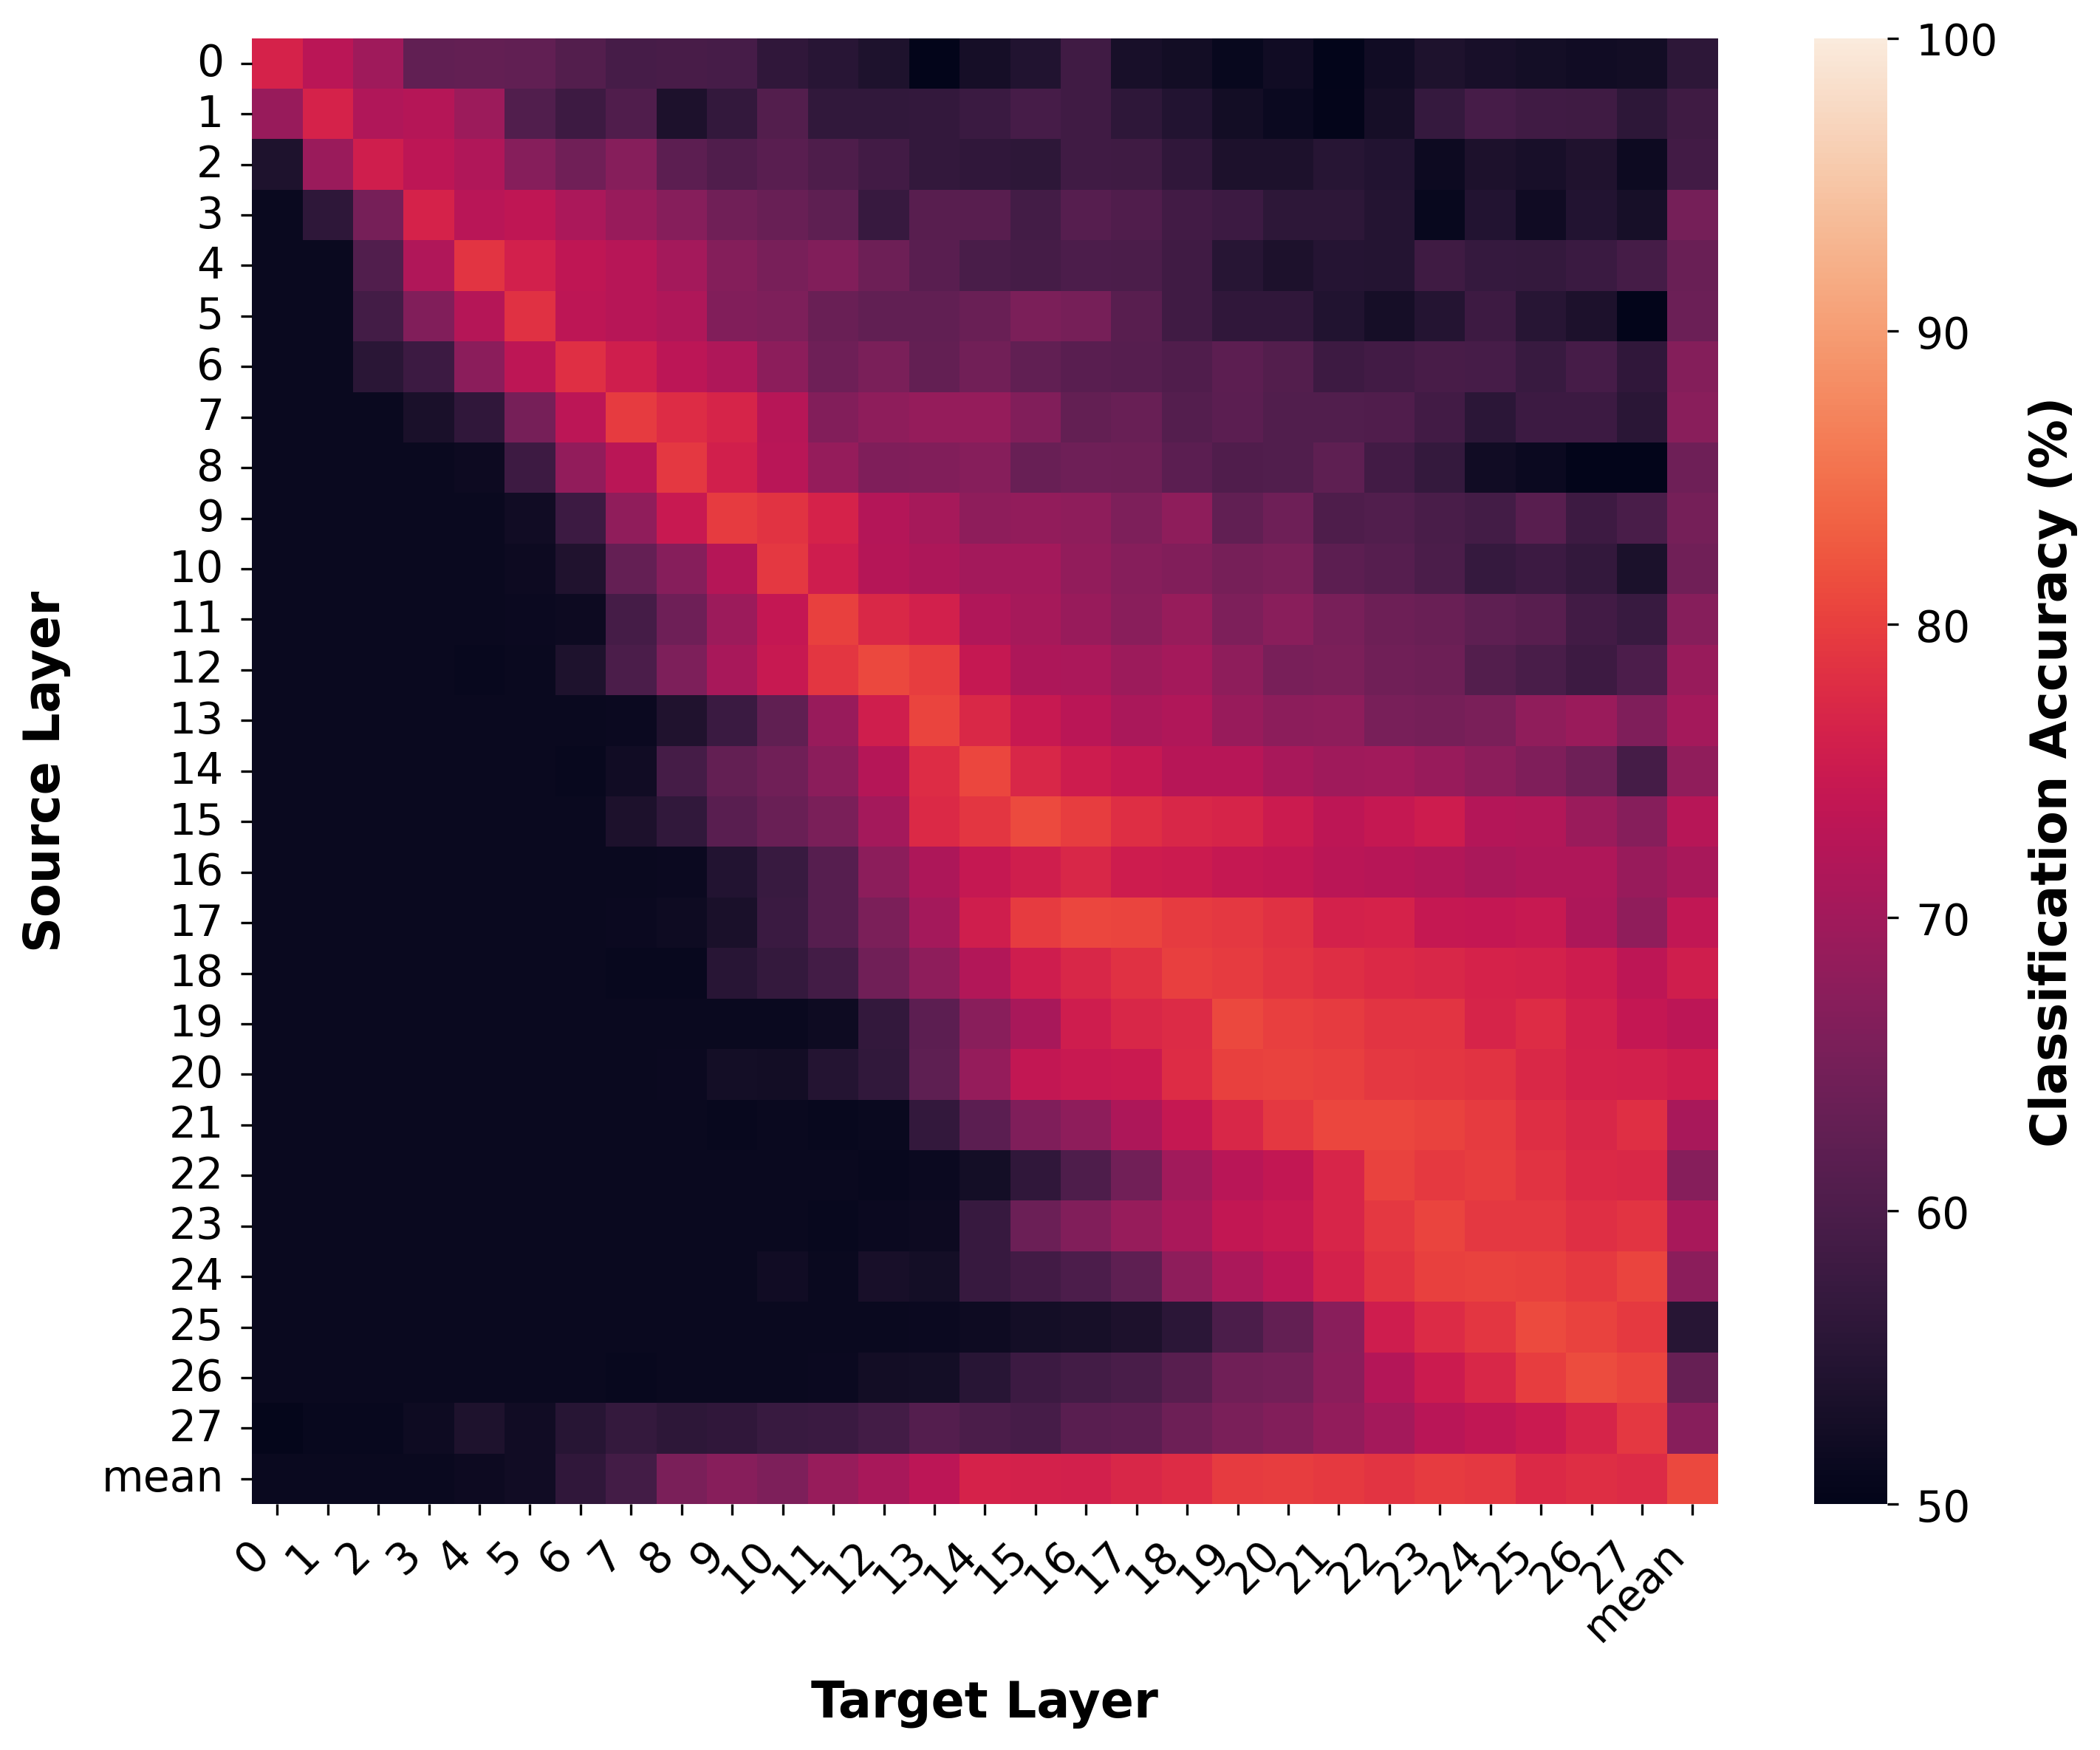

In [30]:
fname_save_template = "datasets/layer_transfer/mlp_layer_accuracies_{save_id}.csv"

for save_id in range(3):    
    test_accuracies_mlp = -1*np.ones((n_layers,n_layers))
    for layer_train in tqdm.tqdm(range(n_layers)):
        mlp = SimpleMLP(input_size=train_activations.shape[-1])
        mlp.to("cuda")
        mlp.train_MLP(train_data = train_activations[:,layer_train,:], train_labels = train_labels, num_epochs = 500)
        for layer_test in range(n_layers):
            test_accuracy, conf_matrix = mlp.get_accuracy(test_data = test_activations[:,layer_test,:], test_labels = test_labels)
            test_accuracies_mlp[layer_train,layer_test] = test_accuracy
    np.savetxt(fname_save_template.format(save_id=save_id), test_accuracies_mlp, delimiter=",")
    
l_test_accuracies = []
for save_id in range(3):
    test_accuracies_i  = np.loadtxt(fname_save_template.format(save_id=save_id), delimiter=",")
    l_test_accuracies.append(test_accuracies_i)

test_accuracies_mean = np.mean(l_test_accuracies, axis=0)

plot_layer_transfer_accuracy(test_accuracies_mean, specifier = "mlp")